<a href="https://colab.research.google.com/github/ddrraaccaarriiss/Cramer/blob/master/House_rental_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting renting cost in KR Model

In this project, we will create a model for predicting the cost of renting residential real estate in Kyrgyzstan

In [8]:
import requests
from bs4 import BeautifulSoup
import lxml

import pandas as pd
pd.set_option('display.float_format', lambda x: '%0.4f' % x)
import numpy as np
np.set_printoptions(suppress=True)

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import legend
import seaborn as sns

import plotly.graph_objects as go
import plotly.express as px

## Read scv

In [9]:
df = pd.read_csv('House_kg.csv')
print(df.shape)
df.info()

(2888, 35)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2888 entries, 0 to 2887
Data columns (total 35 columns):
 #   Column                                                                         Non-Null Count  Dtype  
---  ------                                                                         --------------  -----  
 0   name                                                                           2888 non-null   object 
 1   price                                                                          2888 non-null   object 
 2   location                                                                       2888 non-null   object 
 3   Тип предложения                                                                2888 non-null   object 
 4   Период аренды                                                                  2708 non-null   object 
 5   Серия                                                                          2384 non-null   object 
 6   Дом          

## Extracting the data

We have scapped all ads for real estate rentals in Kyrgyzstan. Let's clean the data

In [10]:
# we will drop all features fullfield less than 30%
col = df.columns
col_res = [i for i in col if df[i].notnull().sum() / df[i].shape[0] > 0.3]
df = df[col_res]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2888 entries, 0 to 2887
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   name             2888 non-null   object
 1   price            2888 non-null   object
 2   location         2888 non-null   object
 3   Тип предложения  2888 non-null   object
 4   Период аренды    2708 non-null   object
 5   Серия            2384 non-null   object
 6   Дом              2336 non-null   object
 7   Этаж             2335 non-null   object
 8   Площадь          2879 non-null   object
 9   Отопление        2100 non-null   object
 10  Состояние        2615 non-null   object
 11  Интернет         1639 non-null   object
 12  Санузел          1644 non-null   object
 13  Газ              1430 non-null   object
 14  Балкон           1188 non-null   object
 15  Входная дверь    1349 non-null   object
 16  Парковка         1176 non-null   object
 17  Мебель           1748 non-null   

### Feature 'name' => type & space

In [11]:
name = 'name'
print('Total values:', df[name].shape[0])
print('Null values:', df[name].isna().sum())
print('Not Null values:', df[name].shape[0] - df[name].isna().sum())

Total values: 2888
Null values: 0
Not Null values: 2888


In [12]:
df.name.head(3)

0                  4-комн. кв., 110 м2
1                   1-комн. кв., 45 м2
2    Коммерческая недвижимость, 100 м2
Name: name, dtype: object

Еhe feature 'name' contain the type of object: ('X-room flat', 'house' or 'Commercial real estate') and the total area.
We will crate 2 new feaures: 'type' and 'space'

In [13]:
# Type of the propoerty

df['type'] = df.name.map(lambda n: n.split(',')[0])
df.drop(index = df[df.type == 'свободная планировка кв.'].index, inplace = True)
df.drop(index = df[df.type == 'Гараж'].index, inplace = True)
df['type'].unique()

array(['4-комн. кв.', '1-комн. кв.', 'Коммерческая недвижимость',
       '3-комн. кв.', '2-комн. кв.', '5-комн. кв.', 'Дом',
       '6 и более комнат кв.', 'Участок', 'Дача'], dtype=object)

In [14]:
# The space of the propoerty

df['space'] = df.name.map(lambda n: n.split(',')[-1])
df['space'] = df['space'].map(lambda n: float(n.replace(' м2', '')) if 'м2' in n else float(n.replace(' соток', '')) / 10000)

In [15]:
df = df.drop(['name', 'Площадь'], axis=1)

### Feature 'price'

In [16]:
name = 'price'
print('Total values:', df[name].shape[0])
print('Null values:', df[name].isna().sum())
print('Not Null values:', df[name].shape[0] - df[name].isna().sum())

Total values: 2883
Null values: 0
Not Null values: 2883


In [17]:
df.price.unique()

array(['$ 700/мес.', '$ 400/мес.', '$ 100/сутки', '$ 1 000/мес.',
       '$ 32/сутки', '$ 23/сутки', '$ 900/мес.', '$ 40/час', '$ 40/сутки',
       '$ 35/час', '$ 35/сутки', '$ 29/сутки', '$ 454', '$ 500', '$ 550',
       '$ 1 100', '$ 575', '$ 850', '$ 2 500', '$ 1 000', '$ 700',
       '$ 681', '$ 715', '$ 600', '$ 1 500', '$ 2 000', '$ 400',
       '$ 69/сутки', '$ 850/мес.', '$ 777', '$ 1 200', '$ 1 300', '$ 800',
       '$ 46/сутки', '$ 625', '$ 568', '$ 5 000', '$ 9 500', '$ 450',
       '$ 350', '$ 300/мес.', '$ 600/мес.', '$ 500/мес.', '$ 576/мес.',
       '$ 2 700/мес.', '$ 2 500/мес.', '$ 346/мес.', '$ 330/мес.',
       '$ 8 580/мес.', '$ 800/мес.', '$ 5 610/мес.', '$ 1 350', '$ 560',
       '$ 650/мес.', '$ 565/мес.', '$ 550/мес.', '$ 750/мес.',
       '$ 553/мес.', '$ 461/мес.', '$ 1 200/мес.', '$ 1 150', '$ 650',
       '$ 3 000', '$ 234 000/мес.', '$ 520', '$ 240', '$ 450/мес.',
       '$ 570', '$ 350/мес.', '$ 1 950', '$ 627', '$ 184/мес.', '$ 580',
       '$ 900', '$ 40

In [18]:
# we will add the period_of_rent feature because the period is strongly influence on price

def duration(x):
  if '/час' in x:
    return 'hour price'
  elif '/сутки' in x:
    return 'daily price'
  else:
    return 'monthly price'

df['period_of_rent'] = df.price.map(duration)

df.period_of_rent.unique()

array(['monthly price', 'daily price', 'hour price'], dtype=object)

In [19]:
def price_clean(p):
  p = p.replace('$ ', '').replace(' ', '')
  if '/час' in p:
    p = float(p.replace(' ', '').replace('/час', '') )      # let's assume that the property will be rented out every day for 8 hours
  elif '/сутки' in p:
    p = float(p.replace(' ', '').replace('/сутки', ''))
  else:
    p = float(p.replace(' ', '').replace('/мес.', ''))    # daily price
  return p

df.price = df.price.map(price_clean)

In [20]:
df.price.sort_values()

1865       12.0000
233        12.0000
2672       12.0000
2140       12.0000
2619       12.0000
           ...    
2115    18000.0000
2207    18000.0000
2063    25000.0000
1650    45000.0000
111    234000.0000
Name: price, Length: 2883, dtype: float64

In [21]:
# to change price to prise per 1 sq.metter
# df.price = df.price / df.space

### Feature 'location'

In [22]:
name = 'location'
print('Total values:', df[name].shape[0])
print('Null values:', df[name].isna().sum())
print('Not Null values:', df[name].shape[0] - df[name].isna().sum())

Total values: 2883
Null values: 0
Not Null values: 2883


In [23]:
df.location.unique()

array(['с. Кок-Джар, Алма-Атинская 7/Южная магистраль',
       'Бишкек, ЖД вокзал, Орозбекова 2/3', 'с. Кош-Коль, с. Кошкол', ...,
       'с. Сары-Ой, нурдолот ата 90 4/6',
       'с. Новопокровка, Эркиндик 33/-',
       'Бишкек, Военторг, Киевская 114/Тоголоко-Молдо'], dtype=object)

In [24]:
df.location = df.location.map(lambda l: l.split(', ')[0].replace(' 17', '').replace(' 19', ''))

In [25]:
df.location.unique()

array(['с. Кок-Джар', 'Бишкек', 'с. Кош-Коль', 'Каракол', 'с. Бостери',
       'с. Чок-Тал', 'с. Сары-Ой', 'с. Таш-Мойнок', 'с. Кашка-Суу',
       'с. Григорьевка', 'с. Булан-Соготту', 'Лебединовка', 'Айкол',
       'Чолпон-Ата', 'с. Маевка', 'с. Беш-Кунгей', 'с. Бактуу-Долоноту',
       'ж/м Биримдик Кут', 'с. Аламудун',
       'с. Корумду (Иссык-Кульский р-н)', 'с. Новопокровка', 'Ош',
       'с. Кара-Ой', 'с. Калтар', 'Токмок', 'с. Чон-Сары-Ой',
       'с. Сары-Ой 3/3', 'с. Бает', 'с. Новопавловка', 'с. Тамга',
       'Сокулук', 'с. Корумду (Тюпский р-н)', 'с. Тон', 'с. Ала-Тоо',
       'с. Орнок', 'с. Садовое (Московский р-н)', 'с. Луч', 'Кант',
       'Кара-Балта', 'Узген', 'с. Тамчы'], dtype=object)

### Feature 'Тип предложения'

In [26]:
name = 'Тип предложения'
print('Total values:', df[name].shape[0])
print('Null values:', df[name].isna().sum())
print('Not Null values:', df[name].shape[0] - df[name].isna().sum())

Total values: 2883
Null values: 0
Not Null values: 2883


In [27]:
df['Тип предложения'].unique()

array(['от собственника', 'от агента'], dtype=object)

In [28]:
# No need to change, just rename
df.rename(columns={'Тип предложения':'proposal_type'}, inplace=True)

### Feature 'Период аренды'

In [29]:
name = 'Период аренды'
print('Total values:', df[name].shape[0])
print('Null values:', df[name].isna().sum())
print('Not Null values:', df[name].shape[0] - df[name].isna().sum())

Total values: 2883
Null values: 180
Not Null values: 2703


In [30]:
df['Период аренды'].unique()

array(['на долгий срок', 'помесячно', 'посуточно', 'по часам', nan],
      dtype=object)

In [31]:
# No need to change, just rename
df.rename(columns={'Период аренды':'rent_period_type'}, inplace=True)

### Feature 'Серия'

In [32]:
name = 'Серия'
print('Total values:', df[name].shape[0])
print('Null values:', df[name].isna().sum())
print('Not Null values:', df[name].shape[0] - df[name].isna().sum())

Total values: 2883
Null values: 502
Not Null values: 2381


In [33]:
df['Серия'].unique()

array(['элитка', nan, 'пентхаус', '105 серия улучшенная',
       'индивид. планировка', '105 серия', '104 серия', '106 серия',
       '108 серия', 'хрущевка', '106 серия улучшенная', 'сталинка',
       '104 серия улучшенная', '107 серия', 'малосемейка', '102 серия'],
      dtype=object)

In [34]:
# No need to change, just rename
df.rename(columns={'Серия':'batch'}, inplace=True)

### Feature 'Дом' => building_type & building_age

In [35]:
name = 'Дом'
print('Total values:', df[name].shape[0])
print('Null values:', df[name].isna().sum())
print('Not Null values:', df[name].shape[0] - df[name].isna().sum())

Total values: 2883
Null values: 550
Not Null values: 2333


In [36]:
df['Дом'].unique()

array(['панельный, 2019 г.', 'монолитный', nan, 'кирпичный, 2015 г.',
       'панельный, 1987 г.', 'кирпичный', 'панельный',
       'монолитный, 2018 г.', 'кирпичный, 2012 г.', 'панельный, 1982 г.',
       'кирпичный, 2011 г.', 'кирпичный, 2020 г.', 'кирпичный, 2017 г.',
       'кирпичный, 2022 г.', 'кирпичный, 2007 г.', 'монолитный, 2011 г.',
       'монолитный, 2020 г.', 'панельный, 1970 г.', 'монолитный, 2014 г.',
       'кирпичный, 2018 г.', 'панельный, 1981 г.', 'кирпичный, 2021 г.',
       'монолитный, 2017 г.', 'кирпичный, 1983 г.', 'кирпичный, 1956 г.',
       'кирпичный, 2008 г.', 'монолитный, 2016 г.', 'кирпичный, 1966 г.',
       'кирпичный, 1997 г.', 'кирпичный, 2016 г.', 'кирпичный, 1961 г.',
       'кирпичный, 2010 г.', 'кирпичный, 1980 г.', 'монолитный, 2006 г.',
       'монолитный, 2013 г.', 'кирпичный, 1985 г.', 'кирпичный, 1974 г.',
       'панельный, 2012 г.', 'монолитный, 2019 г.', 'монолитный, 2022 г.',
       'монолитный, 2021 г.', 'кирпичный, 2009 г.', 'монолитны

In [37]:
def building_age(x):
  if pd.notnull(x):
    if ' г.' in x:
      x = float(x.split(', ')[1].replace(' г.', ''))
      if x > 2010:
        return 'new'
      else:
        return 'old'
    else:
      return np.nan
  else:
    return np.nan

df['building_age'] = df['Дом'].map(building_age)
df['building_age'].unique()

array(['new', nan, 'old'], dtype=object)

In [38]:
df['building_type'] = df['Дом'].map(lambda x: x.split(', ')[0] if pd.notnull(x) else np.nan)
df['building_type'].unique()

array(['панельный', 'монолитный', nan, 'кирпичный'], dtype=object)

In [39]:
df.drop(['Дом'], axis = 1, inplace = True)

### Feature 'Этаж'

In [40]:
name = 'Этаж'
print('Total values:', df[name].shape[0])
print('Null values:', df[name].isna().sum())
print('Not Null values:', df[name].shape[0] - df[name].isna().sum())

Total values: 2883
Null values: 551
Not Null values: 2332


In [41]:
df['Этаж'].unique()

array(['2 этаж из 9', '9 этаж из 10', nan, '11 этаж из 12', '5 этаж из 5',
       '3 этаж из 5', '9 этаж из 12', '4 этаж из 12', '3 этаж из 12',
       '6 этаж из 9', '6 этаж из 12', '5 этаж из 12', '1 этаж из 5',
       '8 этаж из 15', '4 этаж из 10', '2 этаж из 7', '3 этаж из 9',
       '8 этаж из 12', '10 этаж из 10', '1 этаж из 4', '7 этаж из 9',
       '12 этаж из 12', '10 этаж из 16', '4 этаж из 5', '11 этаж из 11',
       '7 этаж из 10', '10 этаж из 12', '5 этаж из 14', '3 этаж из 3',
       '6 этаж из 6', '13 этаж из 13', '4 этаж из 8', '2 этаж из 5',
       '3 этаж из 10', '4 этаж из 4', '9 этаж из 9', '5 этаж из 16',
       '6 этаж из 10', '4 этаж из 9', '5 этаж из 11', '7 этаж из 11',
       '3 этаж из 11', '5 этаж из 13', '2 этаж из 2', '7 этаж из 14',
       '2 этаж из 10', '5 этаж из 17', '8 этаж из 14', '2 этаж из 11',
       '7 этаж из 12', '4 этаж из 14', '5 этаж из 10', '2 этаж из 4',
       '8 этаж из 11', '3 этаж из 13', '8 этаж из 13', '5 этаж из 6',
       '9 этаж

In [42]:
# we will create 2 fetures: floor & number of floors
def get_floor(x):
  if pd.notnull(x):
    if x.split()[-1] != 'этажей':
      floor = x.split()[0]
    else:
      floor = 0
    return floor
  else:
    return np.nan

def get_number_of_floors(x):
  if pd.notnull(x):
    if x.split()[-1] != 'этажей':
      number_of_floors = x.split()[-1]
    else:
      number_of_floors = x.split()[2]
    return number_of_floors
  else:
    return np.nan


df['floor'] = df['Этаж'].map(get_floor)
df['number_of_floors'] = df['Этаж'].map(get_number_of_floors)

df.drop(['Этаж'], axis = 1, inplace = True)

### Feature 'Отопление'

In [43]:
name = 'Отопление'
print('Total values:', df[name].shape[0])
print('Null values:', df[name].isna().sum())
print('Not Null values:', df[name].shape[0] - df[name].isna().sum())

Total values: 2883
Null values: 785
Not Null values: 2098


In [44]:
df['Отопление'].unique()

array(['на газе', 'центральное', 'электрическое', nan, 'автономное',
       'смешанное', 'на твердом топливе', 'без отопления'], dtype=object)

In [45]:
# fillna with 'без отопления' and rename
df['Отопление'].fillna('без отопления', inplace = True)
df.rename(columns={'Отопление':'heating'}, inplace=True)
df.heating.unique()

array(['на газе', 'центральное', 'электрическое', 'без отопления',
       'автономное', 'смешанное', 'на твердом топливе'], dtype=object)

### Feature 'Состояние'

In [46]:
name = 'Состояние'
print('Total values:', df[name].shape[0])
print('Null values:', df[name].isna().sum())
print('Not Null values:', df[name].shape[0] - df[name].isna().sum())

Total values: 2883
Null values: 271
Not Null values: 2612


In [47]:
df['Состояние'].unique()

array(['евроремонт', 'хорошее', nan, 'среднее', 'под самоотделку (псо)'],
      dtype=object)

In [48]:
# No need to change, just rename
df.rename(columns={'Состояние':'codition'}, inplace=True)

### Feature 'Интернет'

In [49]:
name = 'Интернет'
print('Total values:', df[name].shape[0])
print('Null values:', df[name].isna().sum())
print('Not Null values:', df[name].shape[0] - df[name].isna().sum())

Total values: 2883
Null values: 1247
Not Null values: 1636


In [50]:
df['Интернет'].unique()

array(['проводной', 'adsl', nan, 'оптика'], dtype=object)

In [51]:
df['Интернет'] = df['Интернет'].notnull().astype(int).replace({0: 0, 1: 1})
df.rename(columns={'Интернет':'internet'}, inplace=True)
df.internet.unique()

array([1, 0])

### Feature 'Санузел'

In [52]:
name = 'Санузел'
print('Total values:', df[name].shape[0])
print('Null values:', df[name].isna().sum())
print('Not Null values:', df[name].shape[0] - df[name].isna().sum())

Total values: 2883
Null values: 1242
Not Null values: 1641


In [53]:
df['Санузел'].unique()

array(['раздельный', 'совмещенный', nan, '2 с/у и более', 'нет'],
      dtype=object)

In [54]:
# No need to change, just rename
df.rename(columns={'Санузел':'bathroom'}, inplace=True)

### Feature 'Газ'

In [55]:
name = 'Газ'
print('Total values:', df[name].shape[0])
print('Null values:', df[name].isna().sum())
print('Not Null values:', df[name].shape[0] - df[name].isna().sum())

Total values: 2883
Null values: 1455
Not Null values: 1428


In [56]:
df['Газ'].unique()

array(['автономный', 'магистральный', nan, 'нет', 'возможно подключение'],
      dtype=object)

In [57]:
df.rename(columns={'Газ':'gas'}, inplace=True)
df.gas.fillna('нет', inplace = True)
df.gas.str.replace('возможно подключение', 'нет')
df.gas.unique()

array(['автономный', 'магистральный', 'нет', 'возможно подключение'],
      dtype=object)

### Feature 'Балкон'

In [58]:
name = 'Балкон'
print('Total values:', df[name].shape[0])
print('Null values:', df[name].isna().sum())
print('Not Null values:', df[name].shape[0] - df[name].isna().sum())

Total values: 2883
Null values: 1696
Not Null values: 1187


In [59]:
df['Балкон'].unique()

array(['лоджия', 'застекленный балкон', nan, 'нет', 'балкон'],
      dtype=object)

In [60]:
df['Балкон'] = df['Балкон'].replace({'нет': np.nan})
df['Балкон'] = df['Балкон'].apply(lambda x: 1 if pd.notnull(x) else 0)
df.rename(columns={'Балкон':'balcony'}, inplace=True)
df.balcony.unique()

array([1, 0])

### Feature 'Входная дверь'

In [61]:
name = 'Входная дверь'
print('Total values:', df[name].shape[0])
print('Null values:', df[name].isna().sum())
print('Not Null values:', df[name].shape[0] - df[name].isna().sum())

Total values: 2883
Null values: 1536
Not Null values: 1347


In [62]:
df['Входная дверь'].unique()

array(['бронированная', nan, 'деревянная', 'металлическая', 'нет'],
      dtype=object)

In [63]:
# let's drop this feture
df.drop(['Входная дверь'], axis = 1, inplace = True)

### Feature 'Парковка'

In [64]:
name = 'Парковка'
print('Total values:', df[name].shape[0])
print('Null values:', df[name].isna().sum())
print('Not Null values:', df[name].shape[0] - df[name].isna().sum())

df[name].unique()

Total values: 2883
Null values: 1708
Not Null values: 1175


array(['паркинг', nan, 'рядом охраняемая стоянка', 'гараж'], dtype=object)

In [65]:
# we wilchange to yes/no

df['Парковка'] = df['Парковка'].fillna('0')
df['Парковка'].replace(['паркинг', 'гараж', 'рядом охраняемая стоянка'], '1', inplace=True)
df['Парковка'] = df['Парковка'].astype(int)
df.rename(columns={'Парковка':'parking'}, inplace=True)
df.parking.unique()

array([1, 0])

### Feature 'Мебель'

In [66]:
name = 'Мебель'
print('Total values:', df[name].shape[0])
print('Null values:', df[name].isna().sum())
print('Not Null values:', df[name].shape[0] - df[name].isna().sum())

df[name].unique()

Total values: 2883
Null values: 1137
Not Null values: 1746


array(['полностью меблирована', nan, 'частично меблирована', 'пустая'],
      dtype=object)

In [67]:
# No need to change, just rename
df.rename(columns={'Мебель':'furniture'}, inplace=True)

In [68]:
name = 'Пол'
print('Total values:', df[name].shape[0])
print('Null values:', df[name].isna().sum())
print('Not Null values:', df[name].shape[0] - df[name].isna().sum())

df[name].unique()

Total values: 2883
Null values: 1456
Not Null values: 1427


array(['паркет', 'линолеум', nan, 'ламинат', 'ковролин', 'дерево',
       'плитка'], dtype=object)

In [69]:
# No need to change, just rename
df.rename(columns={'Пол':'flooring'}, inplace=True)

### Feature 'Высота потолков'

In [70]:
name = 'Высота потолков'
print('Total values:', df[name].shape[0])
print('Null values:', df[name].isna().sum())
print('Not Null values:', df[name].shape[0] - df[name].isna().sum())

Total values: 2883
Null values: 1431
Not Null values: 1452


In [71]:
df['Высота потолков'].unique()

array(['2.8 м.', '3 м.', nan, '2.7 м.', '3.3 м.', '2.5 м.', '3.5 м.',
       '2.9 м.', '2 м.', '2.3 м.', '4.2 м.', '280 м.', '3.2 м.', '4 м.',
       '5 м.', '33 м.', '3.1 м.', '2.75 м.', '2.1 м.', '11 м.', '3.4 м.',
       '3.8 м.', '7 м.', '2.2 м.', '2800 м.', '28 м.', '2.6 м.', '3.6 м.',
       '300 м.', '3.06 м.', '27 м.', '4.5 м.', '2500 м.', '2.85 м.',
       '290 м.', '240 м.', '35 м.', '180 м.', '270 м.', '285 м.', '85 м.',
       '2.65 м.'], dtype=object)

In [72]:
# just transform ceiling_height to high/low

def ceiling(x):
  if pd.notnull(x):
    x = float(x.split(' ')[0])
    x = 'high' if x > 2.9 else 'low'
  else:
    x = np.nan
  return x

df['Высота потолков'] = df['Высота потолков'].map(ceiling)
df.rename(columns={'Высота потолков':'ceiling_height'}, inplace=True)

df['ceiling_height'].unique()

array(['low', 'high', nan], dtype=object)

### Feature 'Телефон'

In [73]:
name = 'Телефон'
print('Total values:', df[name].shape[0])
print('Null values:', df[name].isna().sum())
print('Not Null values:', df[name].shape[0] - df[name].isna().sum())

df[name].unique()


Total values: 2883
Null values: 1743
Not Null values: 1140


array([nan, 'возможно подключение', 'нет', 'есть'], dtype=object)

In [74]:
df['Телефон'] = df['Телефон'].map(lambda x: 1 if x == 'есть' else 0)
df.rename(columns={'Телефон':'telephone'}, inplace=True)
df.telephone.unique()

array([0, 1])

### Feature 'Безопасность'

Аs a rule, the number of marks in the "safety" feature slightly affects the cost in such a way that the more marks, the cost is slightly more and vice versa, if there are no marks or few, then the cost will be slightly less

In [75]:
df['Безопасность'].unique()

array([nan,
       'домофон,                                             охрана,                                             кодовый замок,                                             видеонаблюдение',
       'кодовый замок',
       'сигнализация,                                             охрана,                                             видеонаблюдение',
       'охрана,                                             кодовый замок,                                             видеонаблюдение,                                             консьерж',
       'домофон',
       'решетки на окнах,                                             сигнализация,                                             охрана,                                             видеонаблюдение',
       'сигнализация,                                             охрана,                                             видеонаблюдение,                                             консьерж',
       'решетки на окнах',
       'решетк

In [76]:
def safety(x):
  if pd.notnull(x):
    l = []
    x = x.split(',')
    for i in x:
      l.append(i.strip())
    return len(l)
  else:
    return 0

df['safety'] = df['Безопасность'].map(safety)
df.drop('Безопасность', axis=1, inplace = True)
df['safety'].unique()

array([0, 4, 1, 3, 2, 5, 8, 7, 6])

In [77]:
# df['Безопасность'][df['Безопасность'].isna()] = '0'

# df['Безопасность-охрана'] = df['Безопасность'].map(lambda x: 'охрана' if 'охрана' in x else np.nan)
# df['Безопасность-кодовый замок'] = df['Безопасность'].map(lambda x: 'кодовый замок' if 'кодовый замок' in x else np.nan)
# df['Безопасность-видеонаблюдение'] = df['Безопасность'].map(lambda x: 'видеонаблюдение' if 'видеонаблюдение' in x else np.nan)
# df['Безопасность-решетки на окнах'] = df['Безопасность'].map(lambda x: 'решетки на окнах' if 'решетки на окнах' in x else np.nan)
# df['Безопасность-видеодомофон'] = df['Безопасность'].map(lambda x: 'видеодомофон' if 'видеодомофон' in x else np.nan)
# df['Безопасность-домофон'] = df['Безопасность'].map(lambda x: 'домофон' if 'домофон' in x else np.nan)
# df['Безопасность-консьерж'] = df['Безопасность'].map(lambda x: 'консьерж' if 'консьерж' in x else np.nan)
# df['Безопасность-сигнализация'] = df['Безопасность'].map(lambda x: 'сигнализация' if 'сигнализация' in x else np.nan)

# df.drop('Безопасность', axis=1, inplace = True)

### Feature 'Разное'

Аs a rule, the number of marks in the "different" feature slightly affects the cost in such a way that the more marks, the cost is slightly more and vice versa, if there are no marks or few, then the cost will be slightly less

In [78]:
def other(x):
  if pd.notnull(x):
    l = []
    x = x.split(',')
    for i in x:
      l.append(i.strip())
    return len(l)
  else:
    return 0

df['equipment'] = df['Разное'].map(other)
df.drop('Разное', axis=1, inplace = True)

df['equipment'].unique()

array([ 0,  5,  3,  6,  4,  1,  2,  7, 10,  8,  9, 11])

## Visualization & cleaning the data

In [79]:
df.columns

Index(['price', 'location', 'proposal_type', 'rent_period_type', 'batch',
       'heating', 'codition', 'internet', 'bathroom', 'gas', 'balcony',
       'parking', 'furniture', 'flooring', 'ceiling_height', 'telephone',
       'type', 'space', 'period_of_rent', 'building_age', 'building_type',
       'floor', 'number_of_floors', 'safety', 'equipment'],
      dtype='object')

In [80]:
df = df[['type', 'space', 'location', 'period_of_rent', 'price', 'rent_period_type', 'proposal_type',
         'batch', 'building_age', 'building_type', 'floor', 'number_of_floors', 'codition',
         'heating',  'internet', 'bathroom', 'gas', 'balcony', 'parking', 'furniture', 'flooring',
         'ceiling_height', 'telephone', 'safety', 'equipment']]

In [81]:
df.shape

(2883, 25)

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2883 entries, 0 to 2887
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   type              2883 non-null   object 
 1   space             2883 non-null   float64
 2   location          2883 non-null   object 
 3   period_of_rent    2883 non-null   object 
 4   price             2883 non-null   float64
 5   rent_period_type  2703 non-null   object 
 6   proposal_type     2883 non-null   object 
 7   batch             2381 non-null   object 
 8   building_age      1029 non-null   object 
 9   building_type     2333 non-null   object 
 10  floor             2332 non-null   object 
 11  number_of_floors  2332 non-null   object 
 12  codition          2612 non-null   object 
 13  heating           2883 non-null   object 
 14  internet          2883 non-null   int64  
 15  bathroom          1641 non-null   object 
 16  gas               2883 non-null   object 


In [83]:
df.head(3)

,type,space,location,period_of_rent,price,rent_period_type,proposal_type,batch,building_age,building_type,...,bathroom,gas,balcony,parking,furniture,flooring,ceiling_height,telephone,safety,equipment
0,4-комн. кв.,110.0000,с. Кок-Джар,monthly price,700.0000,на долгий срок,от собственника,элитка,new,панельный,...,раздельный,автономный,1,1,полностью меблирована,паркет,low,0,0,0
1,1-комн. кв.,45.0000,Бишкек,monthly price,400.0000,помесячно,от собственника,элитка,NaN,монолитный,...,совмещенный,магистральный,1,1,полностью меблирована,линолеум,high,0,4,5
2,Коммерческая недвижимость,100.0000,с. Кош-Коль,daily price,100.0000,посуточно,от собственника,NaN,NaN,NaN,...,NaN,нет,0,0,NaN,NaN,high,0,0,0


In [84]:
def show():
  return df.groupby(by=['type', 'period_of_rent']).agg({'price': ['count', 'min', 'max', 'mean', 'std']})

show()

price                        \
                                         count       min         max   
type                      period_of_rent                               
1-комн. кв.               daily price      235   12.0000   6000.0000   
                          hour price         3   12.0000   2000.0000   
                          monthly price    222   28.0000   1325.0000   
2-комн. кв.               daily price      186   23.0000    180.0000   
                          hour price         3   29.0000     40.0000   
                          monthly price    851  138.0000   2000.0000   
3-комн. кв.               daily price       20   34.0000    150.0000   
                          monthly price    613   52.0000  45000.0000   
4-комн. кв.               daily price        5   34.0000    300.0000   
                          monthly price    149  288.0000   4500.0000   
5-комн. кв.               monthly price     41  560.0000   5000.0000   
6 и более комнат кв.      monthly price      5 1200.0000   3000.0000   
Дача                      daily price        1  150.0000    150.0000   
                          hour price         1   12.0000     12.0000   
Дом                       daily price       65   12.0000    500.0000   
                          monthly price    220   58.0000  12000.0000   
Коммерческая недвижимость daily price       19   12.0000   1500.0000   
                          hour price         2   92.0000    115.0000   
                          monthly price    235   12.0000 234000.0000   
Участок                   monthly price      7  173.0000   5000.0000   

                                                               
                                              mean        std  
type                      period_of_rent                       
1-комн. кв.               daily price      60.7915   389.2992  
                          hour price      680.3333  1142.8965  
                          monthly price   475.9234   157.0802  
2-комн. кв.               daily price      47.5215    23.1965  
                          hour price       34.6667     5.5076  
                          monthly price   708.1445   211.2968  
3-комн. кв.               daily price      54.4000    26.8179  
                          monthly price  1037.7537  1822.4225  
4-комн. кв.               daily price     134.8000   105.5329  
                          monthly price  1410.9060   592.1809  
5-комн. кв.               monthly price  2072.1951   965.5944  
6 и более комнат кв.      monthly price  2020.0000   749.6666  
Дача                      daily price     150.0000        NaN  
                          hour price       12.0000        NaN  
Дом                       daily price     140.2462    91.4195  
                          monthly price  2816.6136  1776.7750  
Коммерческая недвижимость daily price     177.6316   389.7474  
                          hour price      103.5000    16.2635  
                          monthly price  3755.3489 15477.7040  
Участок                   monthly price  2055.7143  1730.1534

### Type

We have only 2 dacha and 7 landplots. We cannot use this information to fit our model if we want good result. So we will drop them and our model will work only for flats, houses and commercial property.

In [85]:
filter = (df.type == 'Дача') | (df.type == 'Участок')
df = df[~filter]
df.shape

(2874, 25)

In [86]:
show()

price                        \
                                         count       min         max   
type                      period_of_rent                               
1-комн. кв.               daily price      235   12.0000   6000.0000   
                          hour price         3   12.0000   2000.0000   
                          monthly price    222   28.0000   1325.0000   
2-комн. кв.               daily price      186   23.0000    180.0000   
                          hour price         3   29.0000     40.0000   
                          monthly price    851  138.0000   2000.0000   
3-комн. кв.               daily price       20   34.0000    150.0000   
                          monthly price    613   52.0000  45000.0000   
4-комн. кв.               daily price        5   34.0000    300.0000   
                          monthly price    149  288.0000   4500.0000   
5-комн. кв.               monthly price     41  560.0000   5000.0000   
6 и более комнат кв.      monthly price      5 1200.0000   3000.0000   
Дом                       daily price       65   12.0000    500.0000   
                          monthly price    220   58.0000  12000.0000   
Коммерческая недвижимость daily price       19   12.0000   1500.0000   
                          hour price         2   92.0000    115.0000   
                          monthly price    235   12.0000 234000.0000   

                                                               
                                              mean        std  
type                      period_of_rent                       
1-комн. кв.               daily price      60.7915   389.2992  
                          hour price      680.3333  1142.8965  
                          monthly price   475.9234   157.0802  
2-комн. кв.               daily price      47.5215    23.1965  
                          hour price       34.6667     5.5076  
                          monthly price   708.1445   211.2968  
3-комн. кв.               daily price      54.4000    26.8179  
                          monthly price  1037.7537  1822.4225  
4-комн. кв.               daily price     134.8000   105.5329  
                          monthly price  1410.9060   592.1809  
5-комн. кв.               monthly price  2072.1951   965.5944  
6 и более комнат кв.      monthly price  2020.0000   749.6666  
Дом                       daily price     140.2462    91.4195  
                          monthly price  2816.6136  1776.7750  
Коммерческая недвижимость daily price     177.6316   389.7474  
                          hour price      103.5000    16.2635  
                          monthly price  3755.3489 15477.7040

### Price & space

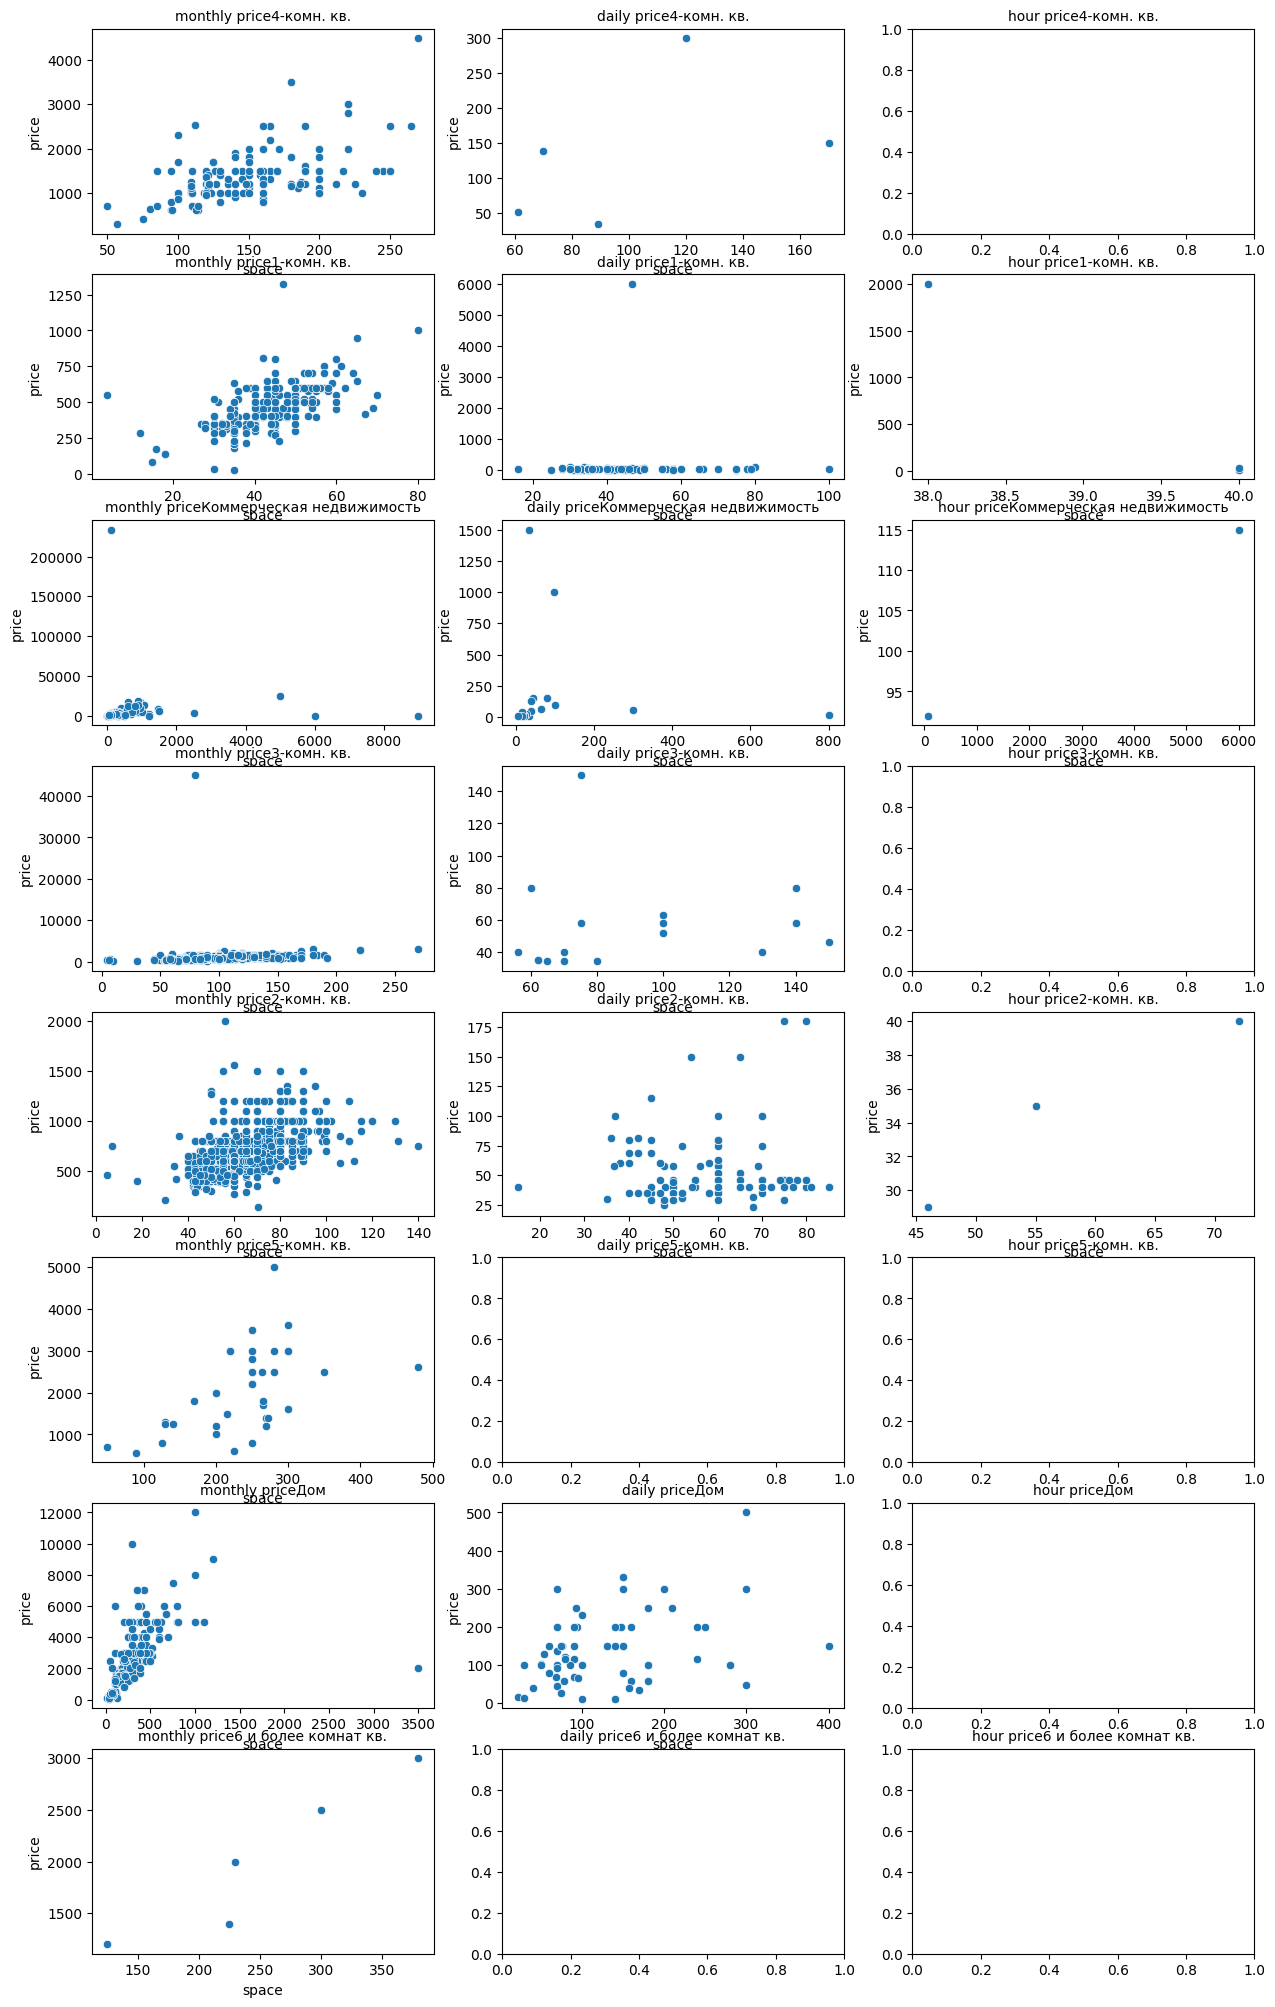

In [87]:
f, axes = plt.subplots(8, 3, figsize=(15, 25))

for i in range(8):
  t = df.type.unique()[i]
  for j in range(3):
    d = df.period_of_rent.unique()[j]
    ttl = str(d) + str(t)
    sns.scatterplot(data = df[(df.type == t) & (df.period_of_rent == d)], x = 'space', y = 'price', ax=axes[i, j]).set_title(ttl, fontsize=10)


We see:

1.  1-badroom appartments have outlier (daily price > 1000 USD). Hour price = 2000 look's exorbitant. Montly price more than 1k - the same
2.  2-badroom appartments have 1 outliers (monthly price > 2k USD)
3.  3-badroom appartments have 2 outliers (monthly price > 10k USD) and (daily price > 100 USD)
4.  4-badroom appartments don't have outliers
5.  5-badroom appartments don't have outliers
6.  6 or more badroom appartments don't have outliers
7.  houses have outlier (monthly-space > 1500)
8.  commercial properties have outliers (monthly price > 50k USD) and (daily price > 300 USD) and (daily-space > 200) and (monthly-space > 2000)

We should remove all outliers

In [88]:
# 1-badroom appartments have outliers (daily price > 1000 USD) and (hour price > 100 USD) and (monthly price > 1100 USD)
outlier_index = df[(df.type == '1-комн. кв.') & (df.period_of_rent == 'daily price') & (df.price > 1000)].index
df.drop(outlier_index, axis = 0, inplace = True)
outlier_index = df[(df.type == '1-комн. кв.') & (df.period_of_rent == 'hour price') & (df.price > 100)].index
df.drop(outlier_index, axis = 0, inplace = True)
outlier_index = df[(df.type == '1-комн. кв.') & (df.period_of_rent == 'monthly price') & (df.price > 1100)].index
df.drop(outlier_index, axis = 0, inplace = True)

# 2-badroom appartments have 1 outliers (monthly price > 2k USD)
outlier_index = df[(df.type == '2-комн. кв.') & (df.period_of_rent == 'monthly price') & (df.price > 1800)].index
df.drop(outlier_index, axis = 0, inplace = True)

# 3-badroom appartments have 2 outliers (monthly price > 10k USD) and (daily price > 100 USD)
outlier_index = df[(df.type == '3-комн. кв.') & (df.period_of_rent == 'monthly price') & (df.price > 10000)].index
df.drop(outlier_index, axis = 0, inplace = True)
outlier_index = df[(df.type == '3-комн. кв.') & (df.period_of_rent == 'daily price') & (df.price > 100)].index
df.drop(outlier_index, axis = 0, inplace = True)

# houses have outlier (monthly-space > 1500)
outlier_index = df[(df.type == 'Дом') & (df.period_of_rent == 'monthly price') & (df.space > 1500)].index
df.drop(outlier_index, axis = 0, inplace = True)

# commercial properties have outliers (monthly price > 50k USD) and (daily price > 300 USD) and (daily-space > 200) and (monthly-space > 2000)
outlier_index = df[(df.type == 'Коммерческая недвижимость') & (df.period_of_rent == 'monthly price') & (df.price > 50000)].index
df.drop(outlier_index, axis = 0, inplace = True)
outlier_index = df[(df.type == 'Коммерческая недвижимость') & (df.period_of_rent == 'daily price') & (df.price > 300)].index
df.drop(outlier_index, axis = 0, inplace = True)
outlier_index = df[(df.type == 'Коммерческая недвижимость') & (df.period_of_rent == 'daily price') & (df.space > 200)].index
df.drop(outlier_index, axis = 0, inplace = True)
outlier_index = df[(df.type == 'Коммерческая недвижимость') & (df.period_of_rent == 'monthly price') & (df.space > 2000)].index
df.drop(outlier_index, axis = 0, inplace = True)

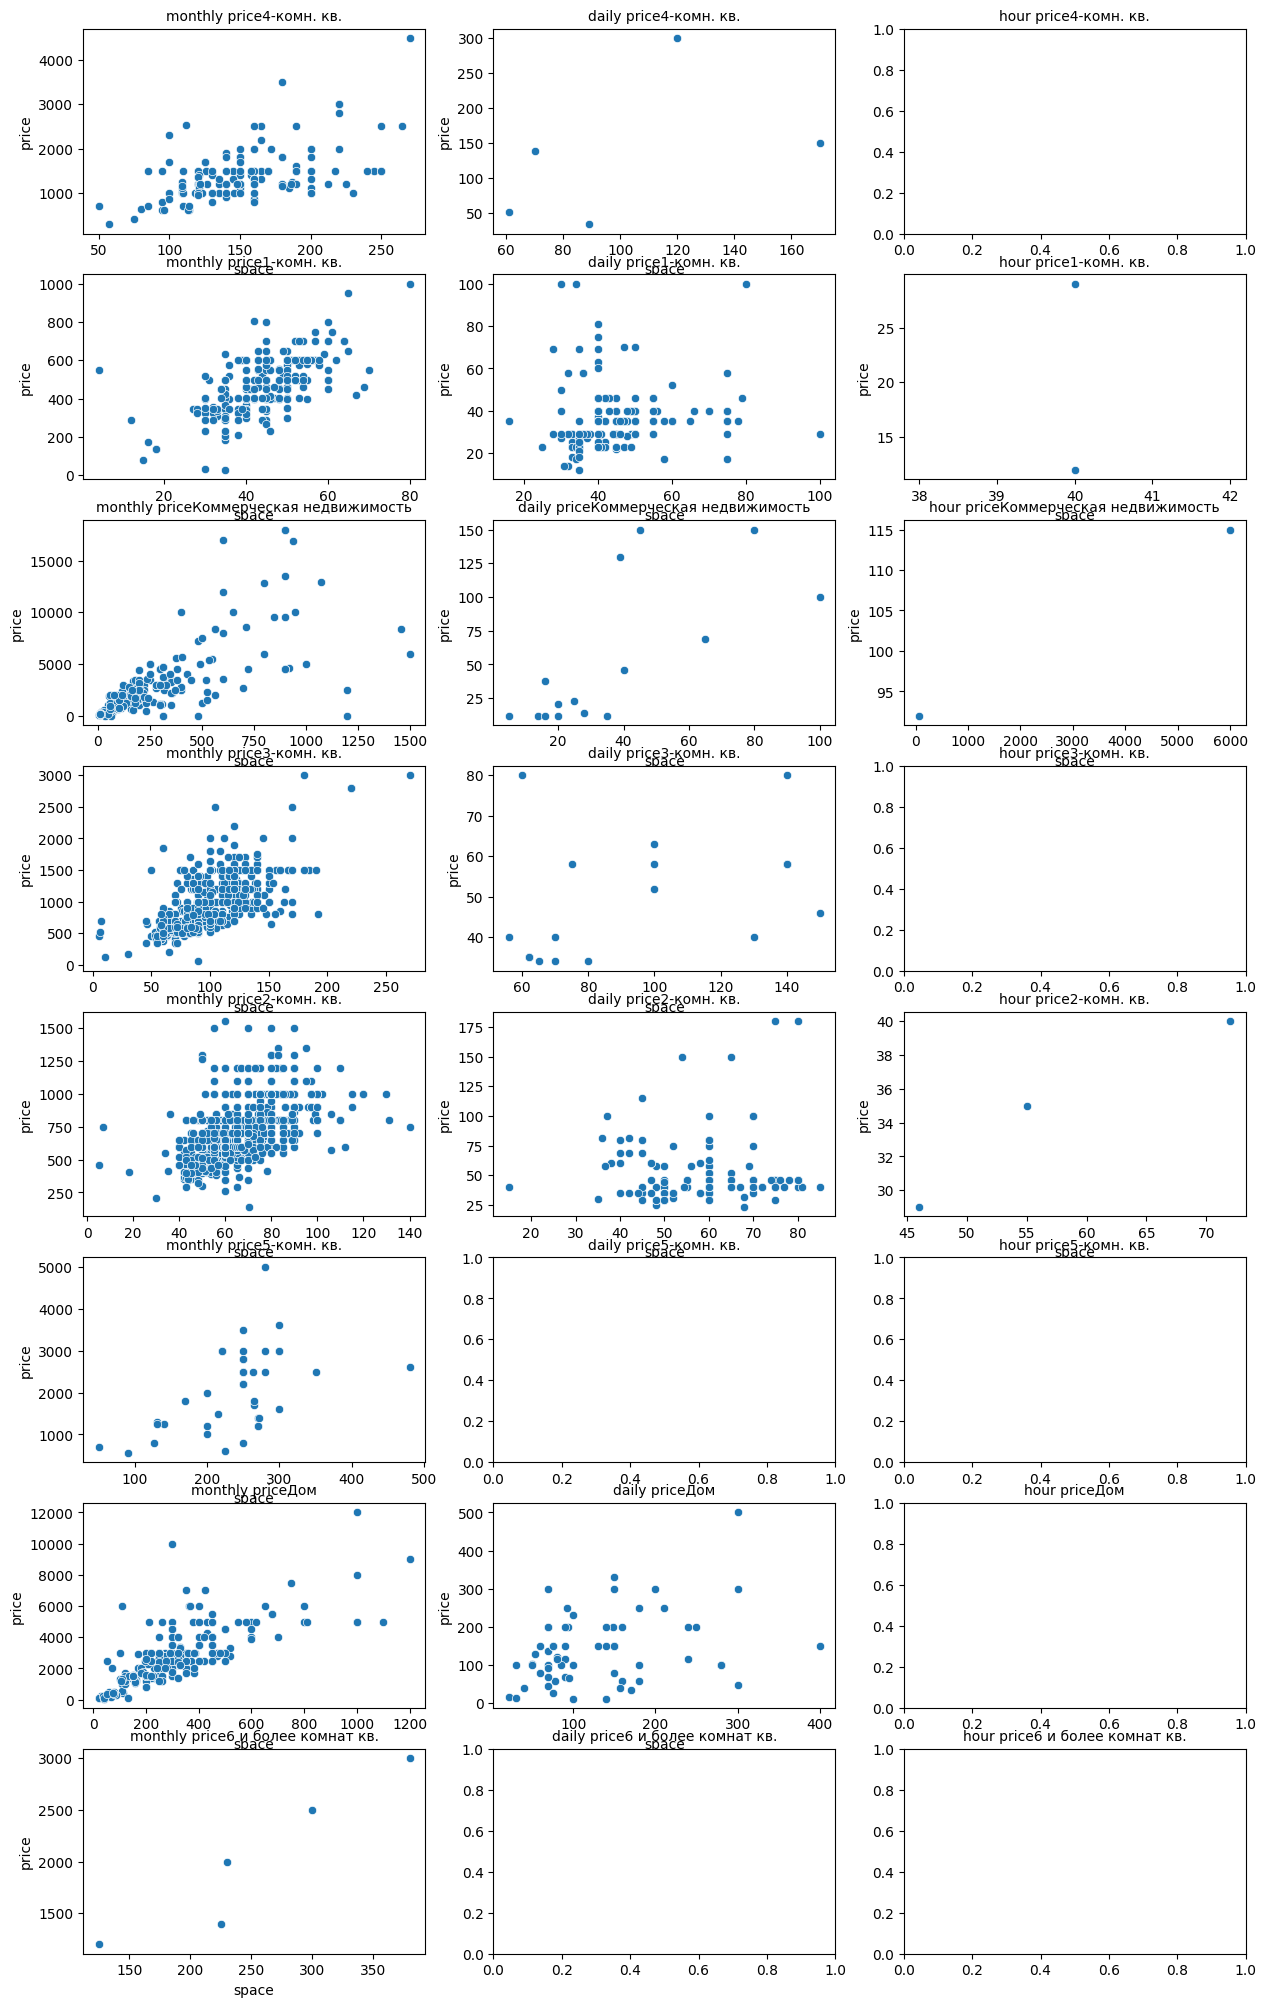

In [89]:
f, axes = plt.subplots(8, 3, figsize=(15, 25))

for i in range(8):
  t = df.type.unique()[i]
  for j in range(3):
    d = df.period_of_rent.unique()[j]
    ttl = str(d) + str(t)
    sns.scatterplot(data = df[(df.type == t) & (df.period_of_rent == d)], x = 'space', y = 'price', ax=axes[i, j]).set_title(ttl, fontsize=10)


Now it looks better. Interestiong distribution for hour price of 1-dabroom apparmens and daily price of 4 badrooms. Let's check

In [90]:
df[(df.type == '1-комн. кв.') & (df.period_of_rent == 'hour price')]

,type,space,location,period_of_rent,price,rent_period_type,proposal_type,batch,building_age,building_type,...,bathroom,gas,balcony,parking,furniture,flooring,ceiling_height,telephone,safety,equipment
1449,1-комн. кв.,40.0000,Бишкек,hour price,12.0000,по часам,от агента,элитка,new,панельный,...,совмещенный,нет,0,1,полностью меблирована,ламинат,low,0,0,0
2773,1-комн. кв.,40.0000,Бишкек,hour price,29.0000,по часам,от собственника,104 серия улучшенная,new,панельный,...,раздельный,магистральный,0,1,полностью меблирована,ламинат,low,0,1,7


In [91]:
df[(df.type == '4-комн. кв.') & (df.period_of_rent == 'daily price')]

,type,space,location,period_of_rent,price,rent_period_type,proposal_type,batch,building_age,building_type,...,bathroom,gas,balcony,parking,furniture,flooring,ceiling_height,telephone,safety,equipment
2081,4-комн. кв.,70.0000,с. Сары-Ой,daily price,138.0000,посуточно,от собственника,элитка,new,монолитный,...,NaN,нет,0,1,NaN,NaN,high,0,0,0
2319,4-комн. кв.,89.0000,Бишкек,daily price,34.0000,посуточно,от собственника,элитка,old,кирпичный,...,раздельный,магистральный,1,1,полностью меблирована,ламинат,high,0,1,6
2343,4-комн. кв.,61.0000,Ош,daily price,52.0000,посуточно,от собственника,105 серия улучшенная,NaN,панельный,...,раздельный,магистральный,1,1,полностью меблирована,дерево,low,0,0,0
2616,4-комн. кв.,120.0000,с. Сары-Ой,daily price,300.0000,посуточно,от собственника,элитка,new,монолитный,...,2 с/у и более,нет,0,1,полностью меблирована,NaN,high,0,0,0
2804,4-комн. кв.,170.0000,Бишкек,daily price,150.0000,посуточно,от собственника,элитка,new,кирпичный,...,2 с/у и более,магистральный,1,1,полностью меблирована,линолеум,high,1,5,6


Strange for 1-badroom appartment. The same space, the same city, but the appartment with lower price is elite building and with a higher price not elite building. Maybe we should drop?

In [92]:
df.drop(df[(df.type == '1-комн. кв.') & (df.period_of_rent == 'hour price')].index, axis = 0, inplace = True)

In [93]:
show()

price                                 \
                                         count       min        max      mean   
type                      period_of_rent                                        
1-комн. кв.               daily price      234   12.0000   100.0000   35.4103   
                          monthly price    221   28.0000  1000.0000  472.0814   
2-комн. кв.               daily price      186   23.0000   180.0000   47.5215   
                          hour price         3   29.0000    40.0000   34.6667   
                          monthly price    850  138.0000  1556.0000  706.6247   
3-комн. кв.               daily price       19   34.0000    80.0000   49.3684   
                          monthly price    612   52.0000  3000.0000  965.9199   
4-комн. кв.               daily price        5   34.0000   300.0000  134.8000   
                          monthly price    149  288.0000  4500.0000 1410.9060   
5-комн. кв.               monthly price     41  560.0000  5000.0000 2072.1951   
6 и более комнат кв.      monthly price      5 1200.0000  3000.0000 2020.0000   
Дом                       daily price       65   12.0000   500.0000  140.2462   
                          monthly price    219   58.0000 12000.0000 2820.3425   
Коммерческая недвижимость daily price       15   12.0000   150.0000   53.4000   
                          hour price         2   92.0000   115.0000  103.5000   
                          monthly price    230   12.0000 18000.0000 2692.6783   

                                                    
                                               std  
type                      period_of_rent            
1-комн. кв.               daily price      12.8819  
                          monthly price   146.6103  
2-комн. кв.               daily price      23.1965  
                          hour price        5.5076  
                          monthly price   206.7146  
3-комн. кв.               daily price      14.9897  
                          monthly price   397.9324  
4-комн. кв.               daily price     105.5329  
                          monthly price   592.1809  
5-комн. кв.               monthly price   965.5944  
6 и более комнат кв.      monthly price   749.6666  
Дом                       daily price      91.4195  
                          monthly price  1779.9825  
Коммерческая недвижимость daily price      53.0051  
                          hour price       16.2635  
                          monthly price  3173.5490

Again we see something wrong:
1.  The monthly price of 1-br app can't be 28 USD. Too low
2.  The monthly price of 2-br app = 1556 is too much. Should be checked
3.  The monthly price of 3-br app can't be 52 USD. Too low
4.  Also houses with monthly price < 100 USD and commercials with monthly price = 12 should be checked

In [94]:
# The monthly price of 1-br app can't be 28 USD. Too low
df[(df.type == '1-комн. кв.') & (df.period_of_rent == 'monthly price') & (df.price < 100)]

,type,space,location,period_of_rent,price,rent_period_type,proposal_type,batch,building_age,building_type,...,bathroom,gas,balcony,parking,furniture,flooring,ceiling_height,telephone,safety,equipment
2143,1-комн. кв.,30.0000,с. Бостери,monthly price,35.0000,помесячно,от собственника,индивид. планировка,new,кирпичный,...,NaN,нет,0,0,NaN,NaN,NaN,0,0,0
2269,1-комн. кв.,35.0000,Бишкек,monthly price,28.0000,на долгий срок,от собственника,104 серия,NaN,кирпичный,...,NaN,нет,0,0,NaN,NaN,NaN,0,0,0
2427,1-комн. кв.,15.0000,Бишкек,monthly price,81.0000,на долгий срок,от собственника,105 серия,NaN,панельный,...,раздельный,нет,0,0,NaN,NaN,NaN,0,0,0


Montly price for 1-br app in Bishkek cannot be 28. I'll drop it

In [95]:
df.drop(df[(df.type == '1-комн. кв.') & (df.period_of_rent == 'monthly price') & (df.price == 28)].index, axis = 0, inplace = True)

In [96]:
# The monthly price of 2-br app = 1556 is too much. Should be checked
df[(df.type == '2-комн. кв.') & (df.period_of_rent == 'monthly price') & (df.price > 1200)]

,type,space,location,period_of_rent,price,rent_period_type,proposal_type,batch,building_age,building_type,...,bathroom,gas,balcony,parking,furniture,flooring,ceiling_height,telephone,safety,equipment
175,2-комн. кв.,90.0000,Бишкек,monthly price,1500.0000,на долгий срок,от агента,элитка,NaN,монолитный,...,совмещенный,магистральный,0,0,NaN,NaN,NaN,0,0,0
259,2-комн. кв.,55.0000,Бишкек,monthly price,1500.0000,помесячно,от агента,элитка,NaN,кирпичный,...,NaN,нет,0,0,NaN,NaN,NaN,0,0,0
388,2-комн. кв.,70.0000,Бишкек,monthly price,1500.0000,на долгий срок,от агента,элитка,NaN,кирпичный,...,раздельный,магистральный,1,1,полностью меблирована,дерево,high,0,7,9
1034,2-комн. кв.,80.0000,Бишкек,monthly price,1300.0000,на долгий срок,от агента,элитка,NaN,монолитный,...,NaN,нет,0,0,NaN,NaN,high,0,0,0
1051,2-комн. кв.,80.0000,Бишкек,monthly price,1300.0000,на долгий срок,от агента,элитка,NaN,монолитный,...,NaN,нет,0,0,NaN,NaN,high,0,0,0
1052,2-комн. кв.,90.0000,Бишкек,monthly price,1300.0000,на долгий срок,от агента,элитка,NaN,монолитный,...,NaN,нет,0,0,NaN,NaN,high,0,0,0
1053,2-комн. кв.,80.0000,Бишкек,monthly price,1300.0000,на долгий срок,от агента,элитка,NaN,монолитный,...,NaN,нет,0,0,NaN,NaN,high,0,0,0
1054,2-комн. кв.,80.0000,Бишкек,monthly price,1300.0000,на долгий срок,от агента,элитка,NaN,монолитный,...,NaN,нет,0,0,NaN,NaN,high,0,0,0
1063,2-комн. кв.,83.0000,Бишкек,monthly price,1350.0000,на долгий срок,от агента,элитка,new,монолитный,...,раздельный,нет,1,1,полностью меблирована,NaN,high,0,4,7
1550,2-комн. кв.,95.0000,Бишкек,monthly price,1350.0000,на долгий срок,от агента,элитка,new,монолитный,...,NaN,нет,0,0,NaN,NaN,high,0,0,0


I am shocked by the prices, but maybe it is reality

In [97]:
# The monthly price of 3-br app can't be 52 USD. Too low
df[(df.type == '3-комн. кв.') & (df.period_of_rent == 'monthly price') & (df.price < 100)]

,type,space,location,period_of_rent,price,rent_period_type,proposal_type,batch,building_age,building_type,...,bathroom,gas,balcony,parking,furniture,flooring,ceiling_height,telephone,safety,equipment
2363,3-комн. кв.,90.0000,с. Булан-Соготту,monthly price,52.0000,помесячно,от собственника,индивид. планировка,NaN,кирпичный,...,совмещенный,нет,1,0,полностью меблирована,NaN,NaN,0,1,3


It's region. Maybe the price is adequate

In [98]:
# Also houses with monthly price < 100 USD and commercials with monthly price = 12 should be checked
df[(df.type == 'Коммерческая недвижимость') & (df.period_of_rent == 'monthly price') & (df.price < 100)]

,type,space,location,period_of_rent,price,rent_period_type,proposal_type,batch,building_age,building_type,...,bathroom,gas,balcony,parking,furniture,flooring,ceiling_height,telephone,safety,equipment
233,Коммерческая недвижимость,315.0000,Бишкек,monthly price,12.0000,на долгий срок,от агента,NaN,NaN,NaN,...,NaN,нет,0,0,NaN,NaN,NaN,0,0,0
897,Коммерческая недвижимость,60.0000,Бишкек,monthly price,69.0000,на долгий срок,от агента,NaN,NaN,NaN,...,NaN,нет,0,0,NaN,NaN,high,0,0,0
1560,Коммерческая недвижимость,5.0000,Бишкек,monthly price,58.0000,помесячно,от собственника,NaN,NaN,NaN,...,NaN,нет,0,0,NaN,NaN,low,0,0,0
1865,Коммерческая недвижимость,65.0000,Ош,monthly price,12.0000,на долгий срок,от собственника,NaN,NaN,NaN,...,NaN,нет,0,0,NaN,NaN,high,1,2,0
1993,Коммерческая недвижимость,315.0000,Бишкек,monthly price,13.0000,на долгий срок,от агента,NaN,NaN,NaN,...,NaN,нет,0,0,NaN,NaN,NaN,0,0,0
2640,Коммерческая недвижимость,480.0000,Бишкек,monthly price,15.0000,на долгий срок,от собственника,NaN,NaN,NaN,...,NaN,нет,0,0,NaN,NaN,high,0,2,0
2711,Коммерческая недвижимость,36.0000,Кант,monthly price,17.0000,на долгий срок,от собственника,NaN,NaN,NaN,...,NaN,нет,0,0,NaN,NaN,NaN,0,0,0
2833,Коммерческая недвижимость,1200.0000,Бишкек,monthly price,16.0000,на долгий срок,от собственника,NaN,NaN,NaN,...,NaN,нет,0,0,NaN,NaN,NaN,0,0,0


In [99]:
df[(df.type == 'Дом') & (df.period_of_rent == 'monthly price') & (df.price < 100)]

,type,space,location,period_of_rent,price,rent_period_type,proposal_type,batch,building_age,building_type,...,bathroom,gas,balcony,parking,furniture,flooring,ceiling_height,telephone,safety,equipment
1109,Дом,20.0000,Бишкек,monthly price,69.0000,на долгий срок,от собственника,NaN,NaN,NaN,...,NaN,нет,0,0,NaN,NaN,NaN,0,0,0
2282,Дом,40.0000,с. Садовое (Московский р-н),monthly price,58.0000,на долгий срок,от собственника,NaN,NaN,NaN,...,NaN,нет,0,0,NaN,NaN,NaN,0,0,0


Maybe normal, maybe not. lets skip and we will see

### Location

In [100]:
df.groupby('location').agg({'type':'count'}).rename({'type':'type_count'}, axis = 1).sort_values('type_count', ascending = False).T

location,Бишкек,с. Сары-Ой,Ош,с. Чок-Тал,с. Бостери,Чолпон-Ата,с. Кок-Джар,с. Кош-Коль,Каракол,Лебединовка,...,с. Сары-Ой 3/3,Кара-Балта,с. Бает,с. Ала-Тоо,с. Григорьевка,с. Новопавловка,с. Маевка,с. Луч,Узген,с. Орнок
type_count,2626,41,26,25,23,21,19,9,6,5,...,1,1,1,1,1,1,1,1,1,1


Too much locations with only 1 proposal. let's drop locations with number of proposals less then 10

In [101]:
tmp = df.groupby('location').agg({'type':'count'}).rename({'type':'type_count'}, axis = 1).sort_values('type_count', ascending = False)
tmp = tmp[tmp.type_count < 10].index.values
df = df[~df.location.isin(tmp)]

Text(0.5, 1.0, 'Distribution by location')

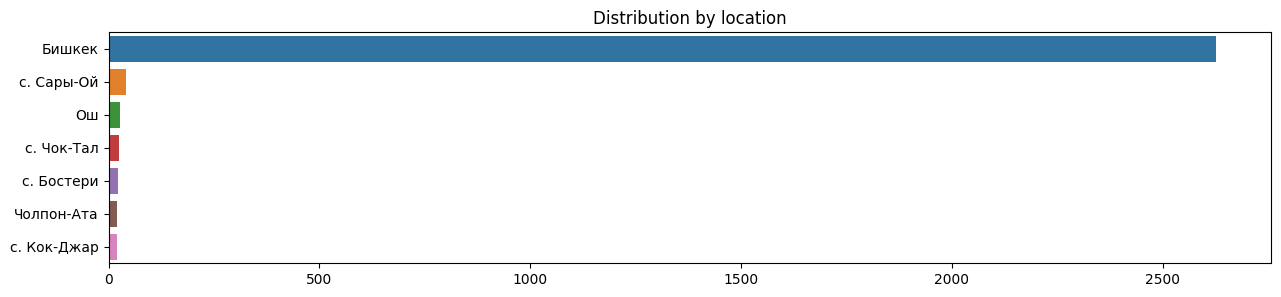

In [102]:
plt.subplots(figsize = (15, 3))
df_location_temp = df.location.value_counts()
sns.barplot(x = df_location_temp.values, y = df_location_temp.index)
plt.title('Distribution by location')

### period_of_rent & rent_period_type

In [103]:
df.groupby(by=['rent_period_type', 'period_of_rent']).agg({'price':'count'})

,,price
rent_period_type,period_of_rent,
на долгий срок,monthly price,1980
по часам,hour price,5
помесячно,monthly price,130
посуточно,daily price,489


Total number of monthly price advs is 2110 and only 130 of them are for month. Thus 'rent_period_type' is almost fully correlated with 'period_of_rent' and can be dropped

In [104]:
df.drop('rent_period_type', axis = 1, inplace = True)

### proposal_type

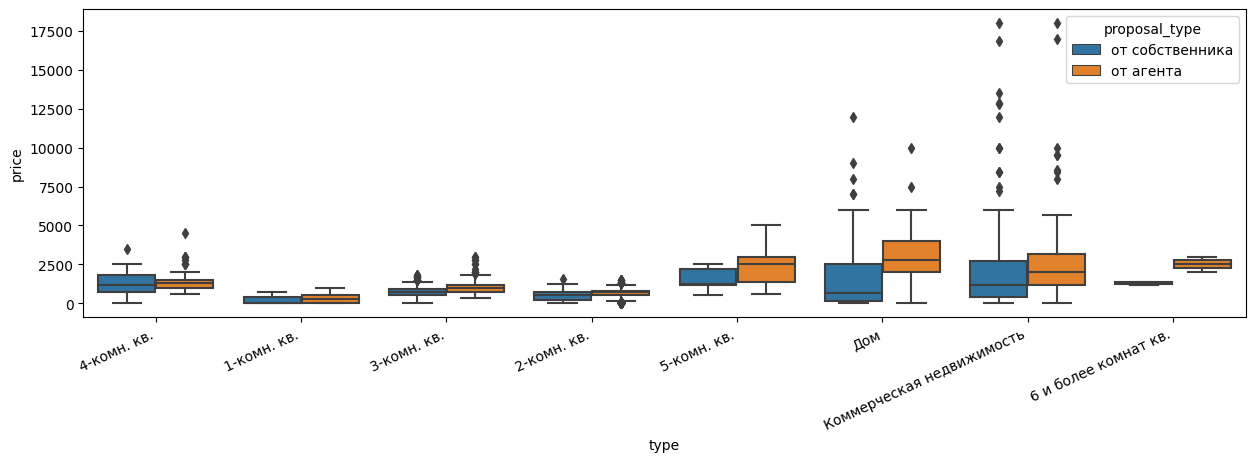

In [105]:
# sns.boxplot(x = df.proposal_type, y = df.price)
plt.figure(figsize=(15,4))
sns.boxplot(data = df, x='type', y = 'price', hue = 'proposal_type')
plt.xticks(rotation=25, ha='right')
plt.show()

Nothing interesting. Agency price is little bit higher than owner price. This is obvious

### Batch

Hypothesis: the rental price of the elite is more than the rest of the apartments

In [106]:
df.batch.unique()

array(['элитка', 'пентхаус', 'индивид. планировка', '105 серия',
       '104 серия', nan, '106 серия', '108 серия', 'хрущевка',
       '106 серия улучшенная', '105 серия улучшенная', 'сталинка',
       '104 серия улучшенная', '107 серия', 'малосемейка', '102 серия'],
      dtype=object)

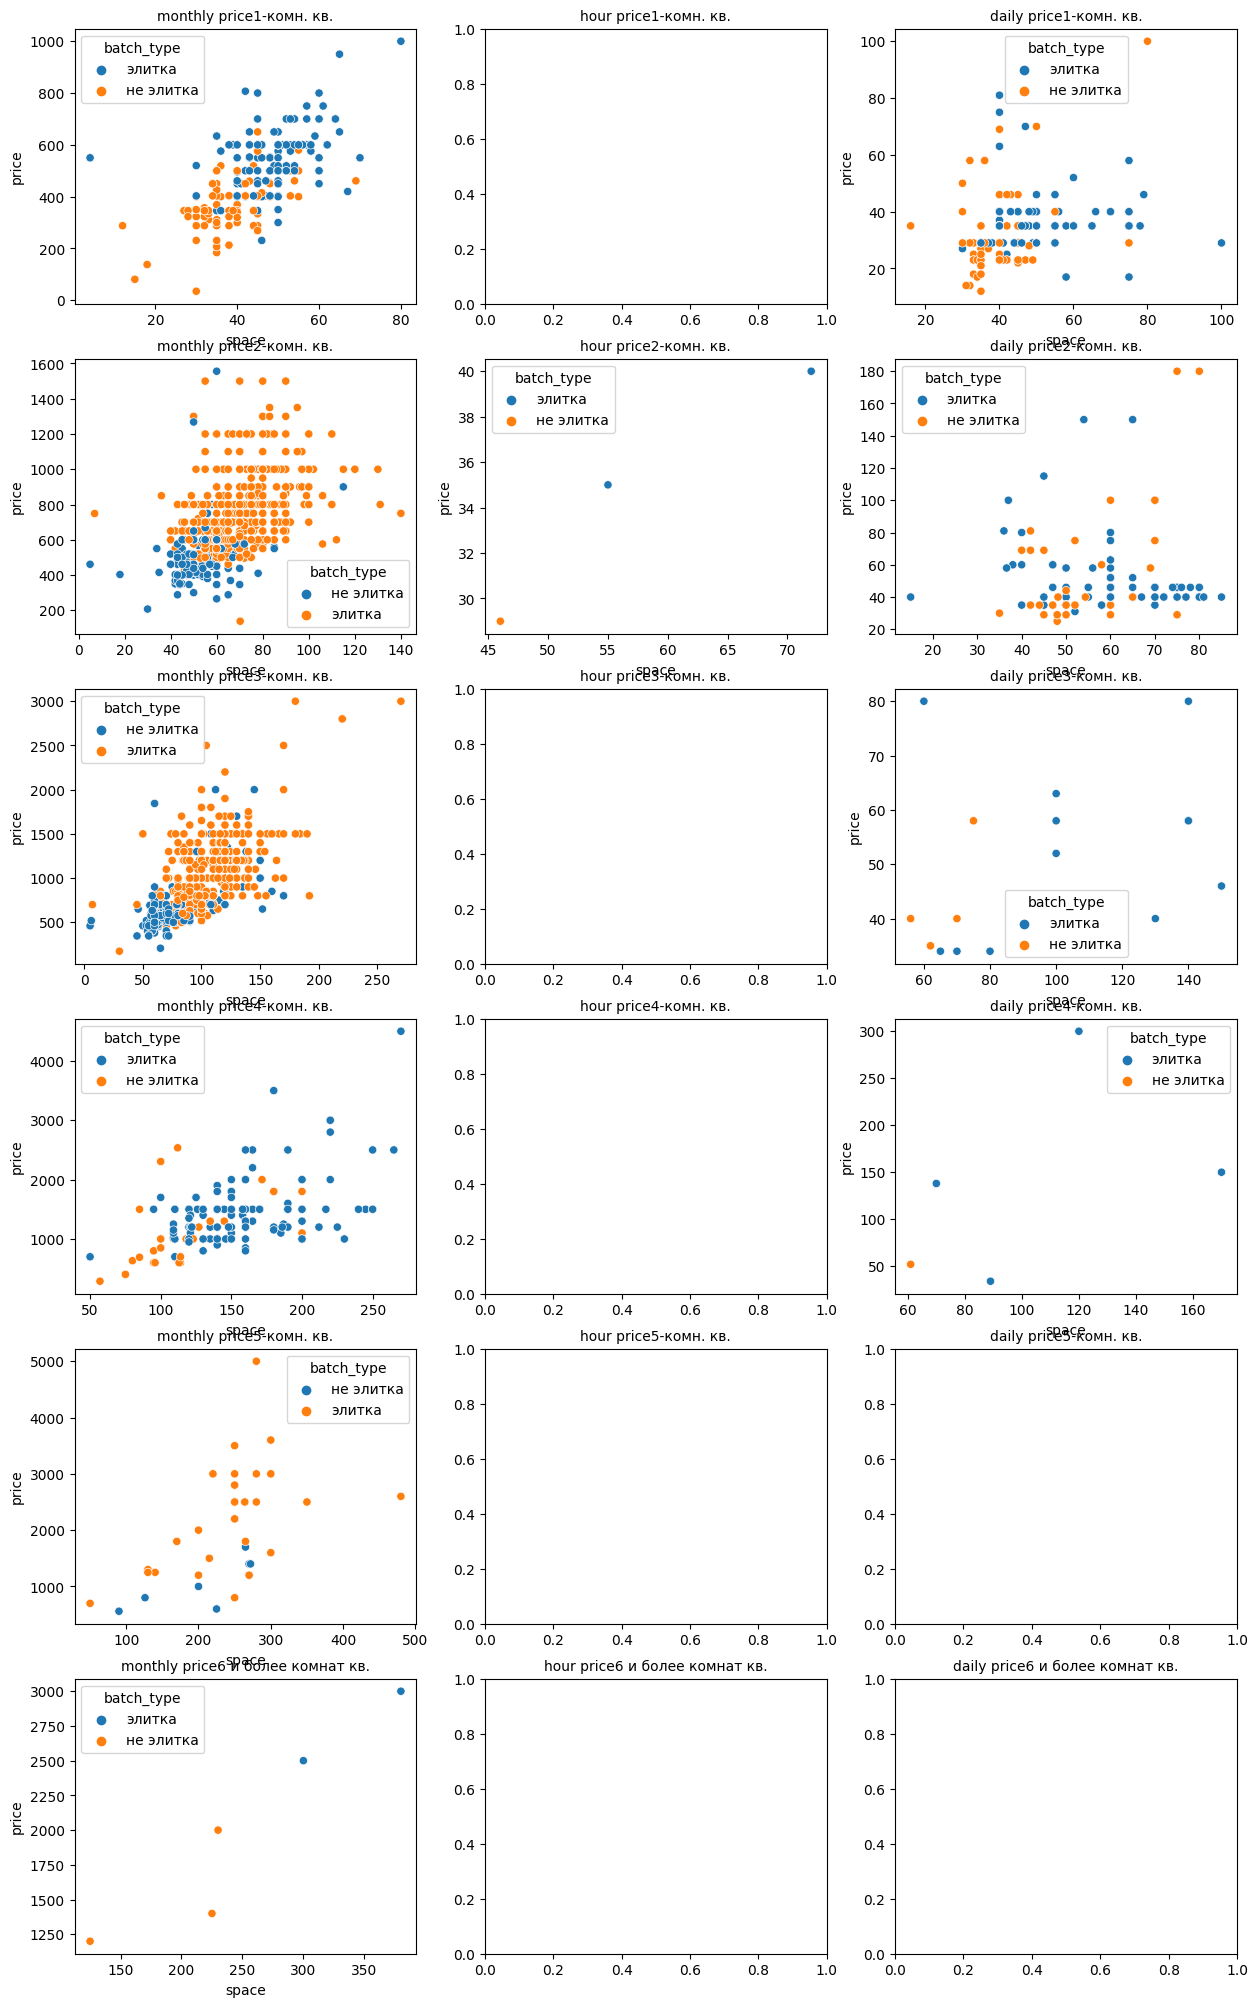

In [107]:
df['batch_type'] = df.batch.map(lambda x: 'элитка' if x == 'элитка' else 'не элитка')

f, axes = plt.subplots(6, 3, figsize=(15, 25))
appartments = ['1-комн. кв.', '2-комн. кв.', '3-комн. кв.', '4-комн. кв.', '5-комн. кв.', '6 и более комнат кв.']
for i in range(6):
  t = appartments[i]
  for j in range(3):
    d = df.period_of_rent.unique()[j]
    ttl = str(d) + str(t)
    sns.scatterplot(data = df[(df.type == t) & (df.period_of_rent == d)], x = 'space', y = 'price', hue = 'batch_type', ax=axes[i, j]).set_title(ttl, fontsize=10)


Indeed, the price of renting an elite apartment is more than the rest of the apartments. We will change this feature to binary

In [108]:
df.batch = df.batch.map(lambda x: 1 if x == 'элитка' else 0)
df.drop('batch_type', axis = 1, inplace = True)

### 'building_age', 'building_type'

In [109]:
df.building_type.unique()

array(['панельный', 'монолитный', 'кирпичный', nan], dtype=object)

In [110]:
df.building_age.unique()

array(['new', nan, 'old'], dtype=object)

<ipython-input-111-7cec99425e18>:8: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data = df[(df.type == t) & (df.period_of_rent == d)], x = 'price', hue = 'building_age', ax=axes[i, j]).set_title(ttl, fontsize=10)
<ipython-input-111-7cec99425e18>:8: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data = df[(df.type == t) & (df.period_of_rent == d)], x = 'price', hue = 'building_age', ax=axes[i, j]).set_title(ttl, fontsize=10)
<ipython-input-111-7cec99425e18>:8: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data = df[(df.type == t) & (df.period_of_rent == d)], x = 'price', hue = 'building_age', ax=axes[i, j]).set_title(ttl, fontsize=10)
<ipython-input-111-7cec99425e18>:8: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `

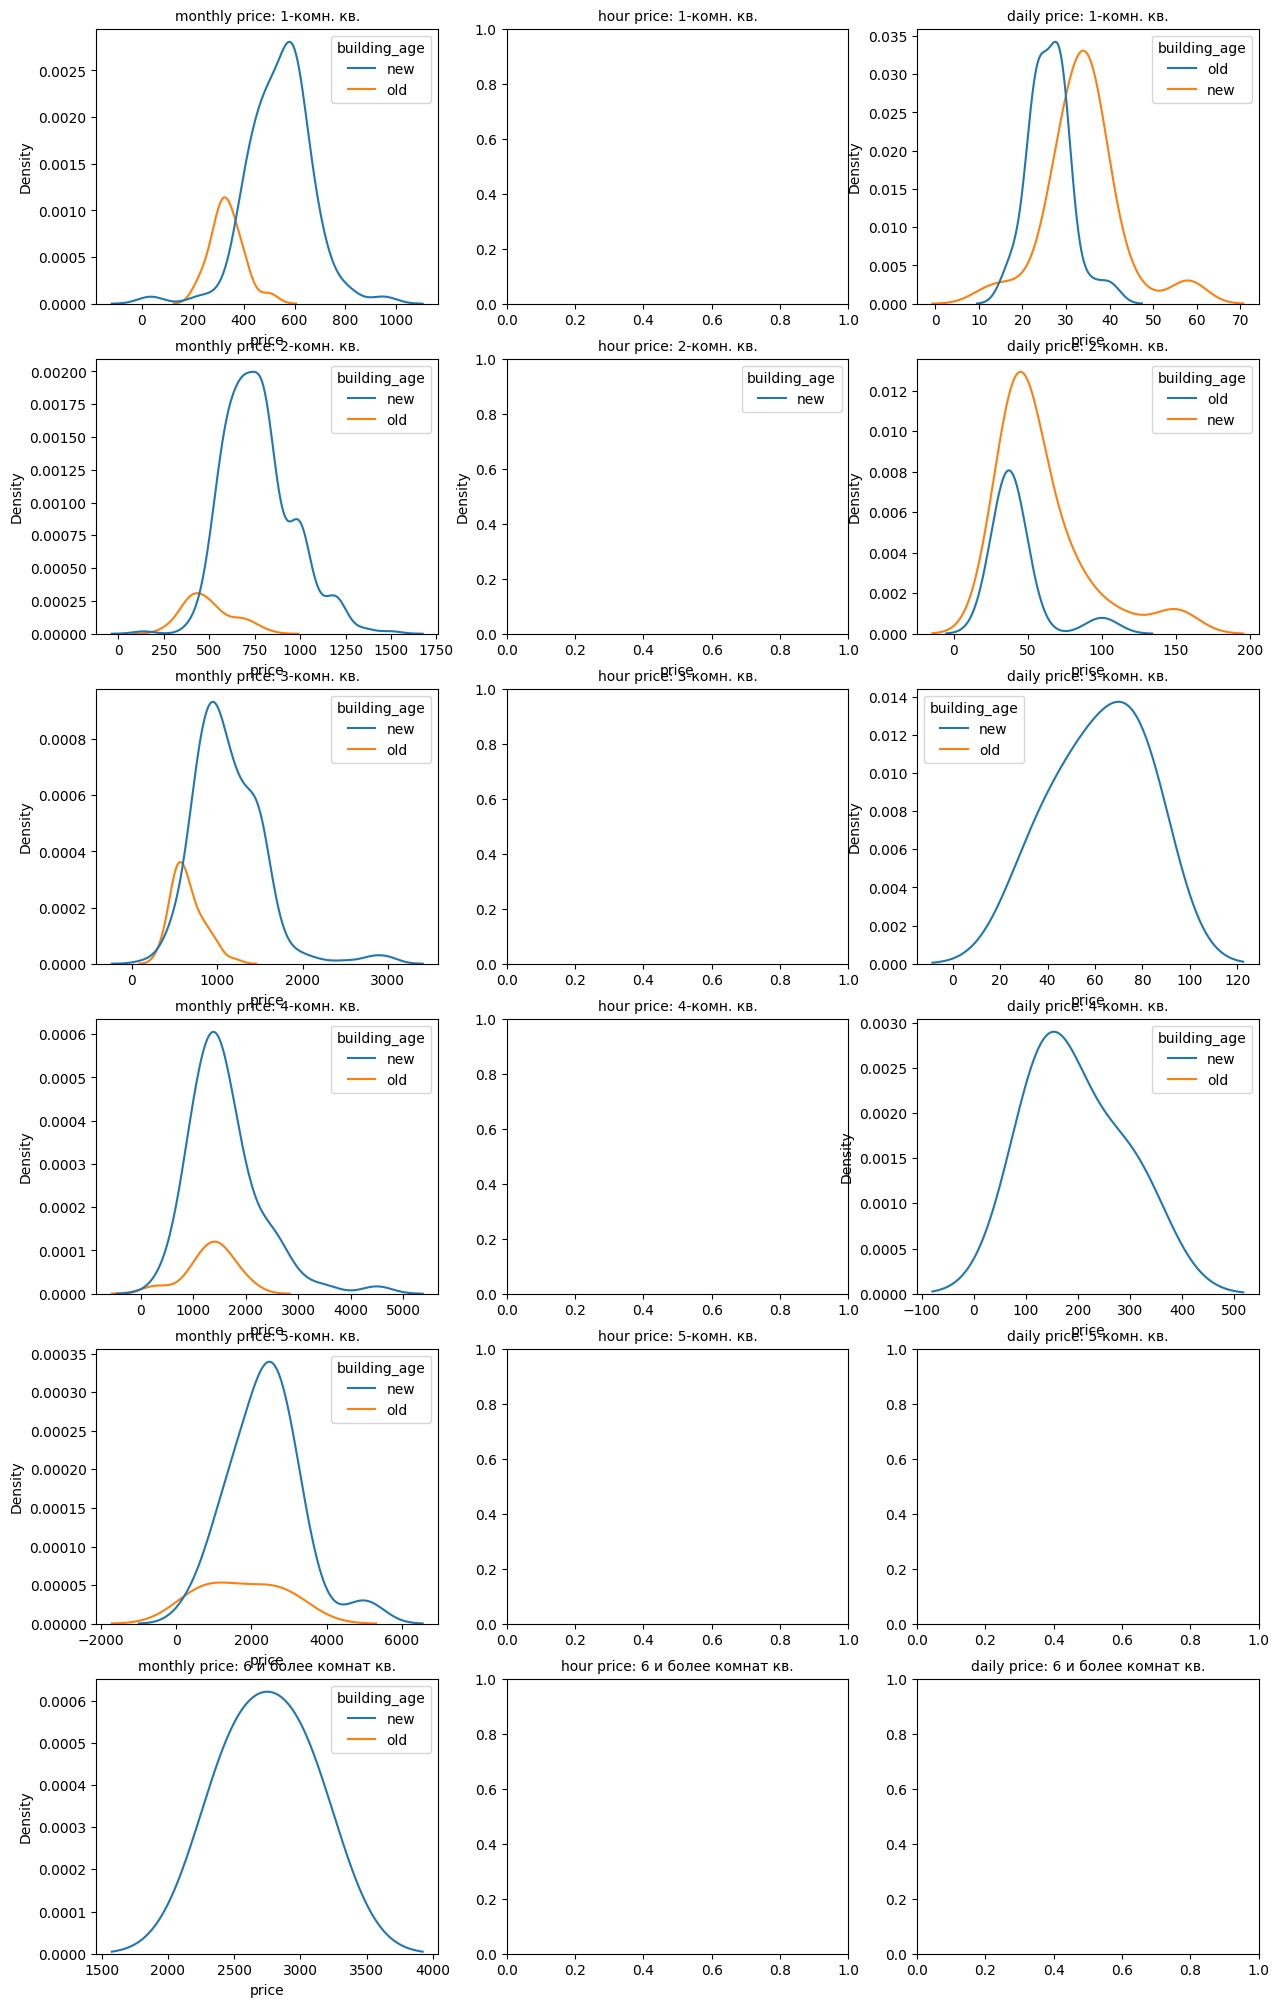

In [111]:
f, axes = plt.subplots(6, 3, figsize=(15, 25))

for i in range(6):
  t = appartments[i]
  for j in range(3):
    d = df.period_of_rent.unique()[j]
    ttl = str(d) + ': ' + str(t)
    sns.kdeplot(data = df[(df.type == t) & (df.period_of_rent == d)], x = 'price', hue = 'building_age', ax=axes[i, j]).set_title(ttl, fontsize=10)


We see that the rent price of app in new buildings is higher. The distribution is closed to normal. No need to change anything.
Let's check the building type correlation

In [112]:
df.building_type.value_counts()

кирпичный     1117
монолитный     976
панельный      208
Name: building_type, dtype: int64

Text(0.5, 1.0, '6 и более комнат кв.')

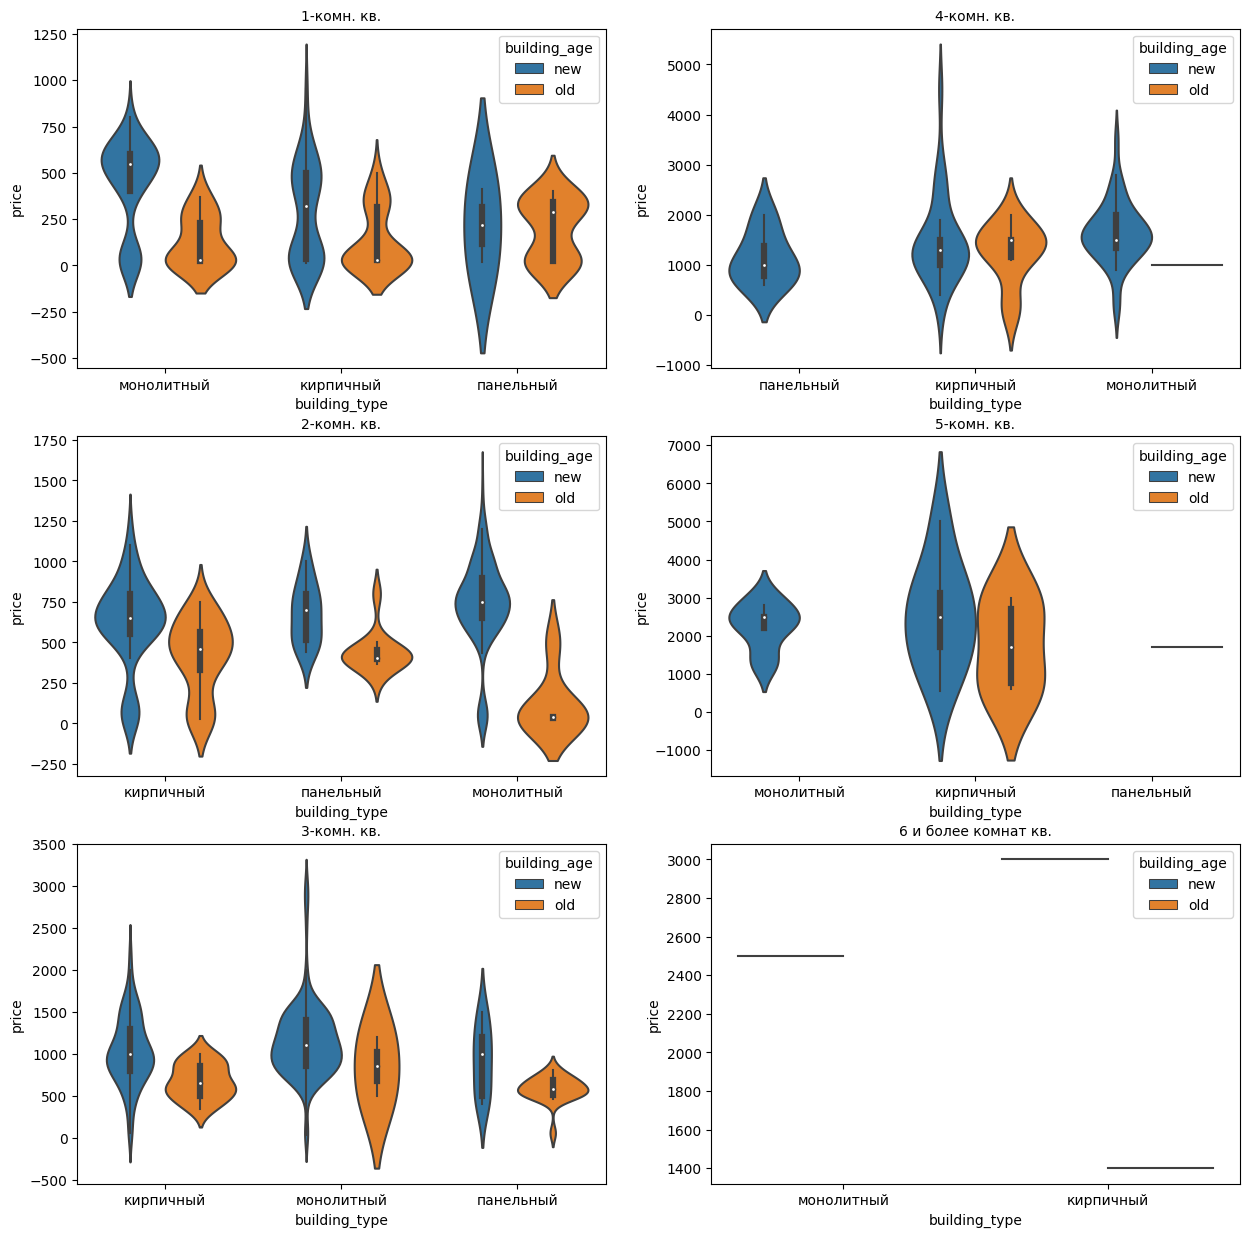

In [113]:
f, axes = plt.subplots(3, 2, figsize=(15, 15))

sns.violinplot(data = df[(df.type == '1-комн. кв.')], x = 'building_type', y= 'price', hue = 'building_age', ax=axes[0, 0]).set_title('1-комн. кв.', fontsize=10)
sns.violinplot(data = df[(df.type == '2-комн. кв.')], x = 'building_type', y= 'price', hue = 'building_age', ax=axes[1, 0]).set_title('2-комн. кв.', fontsize=10)
sns.violinplot(data = df[(df.type == '3-комн. кв.')], x = 'building_type', y= 'price', hue = 'building_age', ax=axes[2, 0]).set_title('3-комн. кв.', fontsize=10)
sns.violinplot(data = df[(df.type == '4-комн. кв.')], x = 'building_type', y= 'price', hue = 'building_age', ax=axes[0, 1]).set_title('4-комн. кв.', fontsize=10)
sns.violinplot(data = df[(df.type == '5-комн. кв.')], x = 'building_type', y= 'price', hue = 'building_age', ax=axes[1, 1]).set_title('5-комн. кв.', fontsize=10)
sns.violinplot(data = df[(df.type == '6 и более комнат кв.')], x = 'building_type', y= 'price', hue = 'building_age', ax=axes[2, 1]).set_title('6 и более комнат кв.', fontsize=10)

The building type does't greatly affect. But we'll keep this future

### 'floor', 'number_of_floors'

As a rule, middle floors are more appreciated in Bishkek. The upper floors are least appreciated. Let's check it out

In [114]:
df['floor_type'] = df.floor.astype('float') / df.number_of_floors.astype('float')

bins = [df.floor_type.min(), .2, .7, df.floor_type.max()]
labels = ['low', 'medium', 'high']
df.floor_type = pd.cut(df.floor_type, bins = bins, labels = labels)

<Axes: xlabel='type', ylabel='price'>

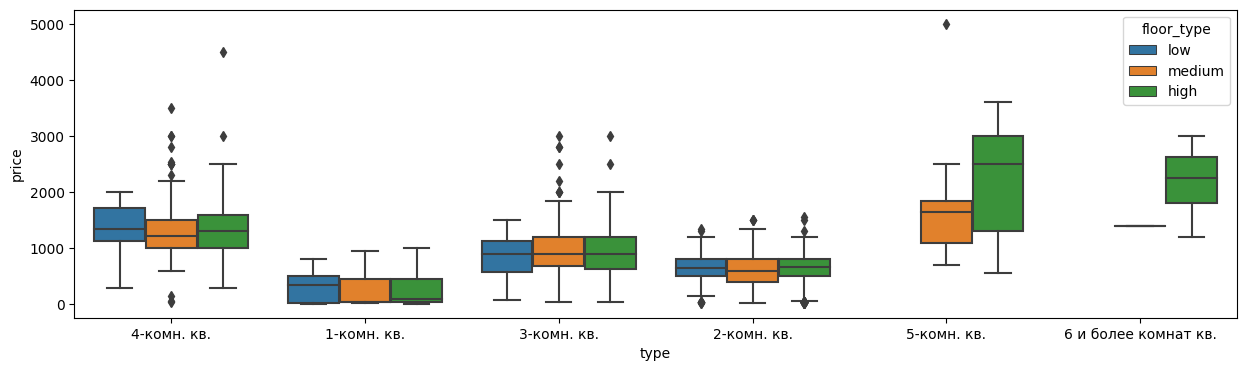

In [115]:
plt.figure(figsize=(15,4))
sns.boxplot(data = df[df.type.isin(appartments)], x='type', y = 'price', hue = 'floor_type')

Strange. It seems that the price of renting apartments on the upper floors is higher. Let's leave this features

In [116]:
# df.drop(['floor', 'number_of_floors'], axis = 1, inplace = True)
df.drop(['floor_type'], axis = 1, inplace = True)

### 'safety', 'equipment'

The value of the features safety and equipment corresponds to the number of specified components.
Hypothesis: the higher the value, the higher the price

In [117]:
df.safety.unique()

array([0, 4, 3, 1, 2, 5, 8, 7, 6])

In [118]:
df.equipment.unique()

array([ 0,  5,  3,  6,  4,  1,  2,  7, 10,  8,  9, 11])

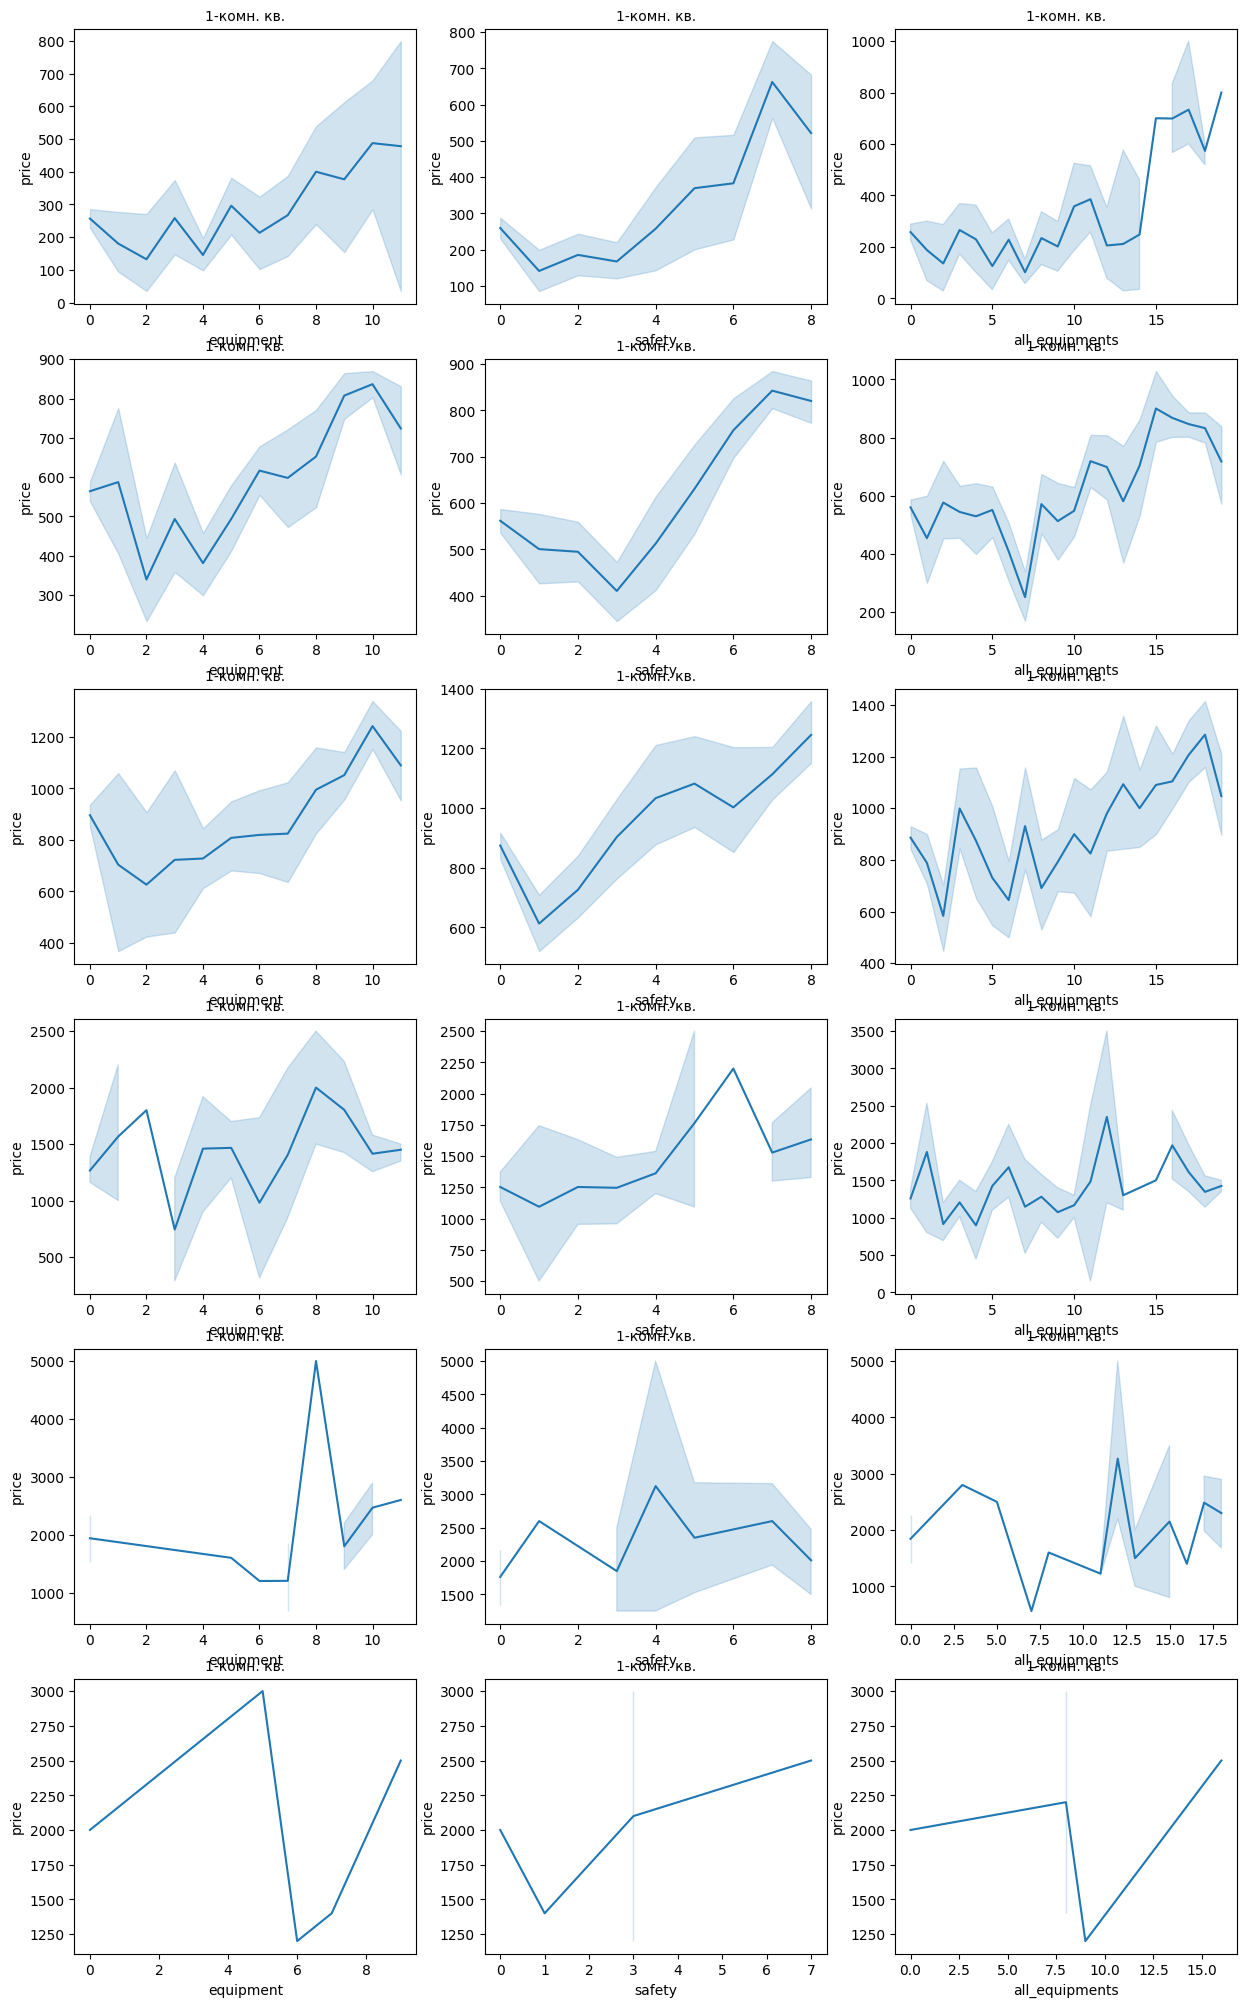

In [119]:
df['all_equipments'] = df.equipment + df.safety

cols = ['equipment', 'safety', 'all_equipments']
f, axes = plt.subplots(6, 3, figsize=(15, 25))

for i in range(6):
  t = appartments[i]
  for j in range(3):
    d = cols[j]
    ttl = str(d) + str(t)
    sns.lineplot(data = df[(df.type == t)], x = d, y= 'price', ax=axes[i, j]).set_title('1-комн. кв.', fontsize=10)

Оbviously there is a slight trend to increase. the more components specified, the higher the price.

In [120]:
df.drop(['all_equipments'], axis = 1, inplace = True)

### Other components ['codition', 'heating', 'internet', 'bathroom', 'gas', 'balcony', 'parking', 'furniture', 'flooring', 'ceiling_height', 'telephone']

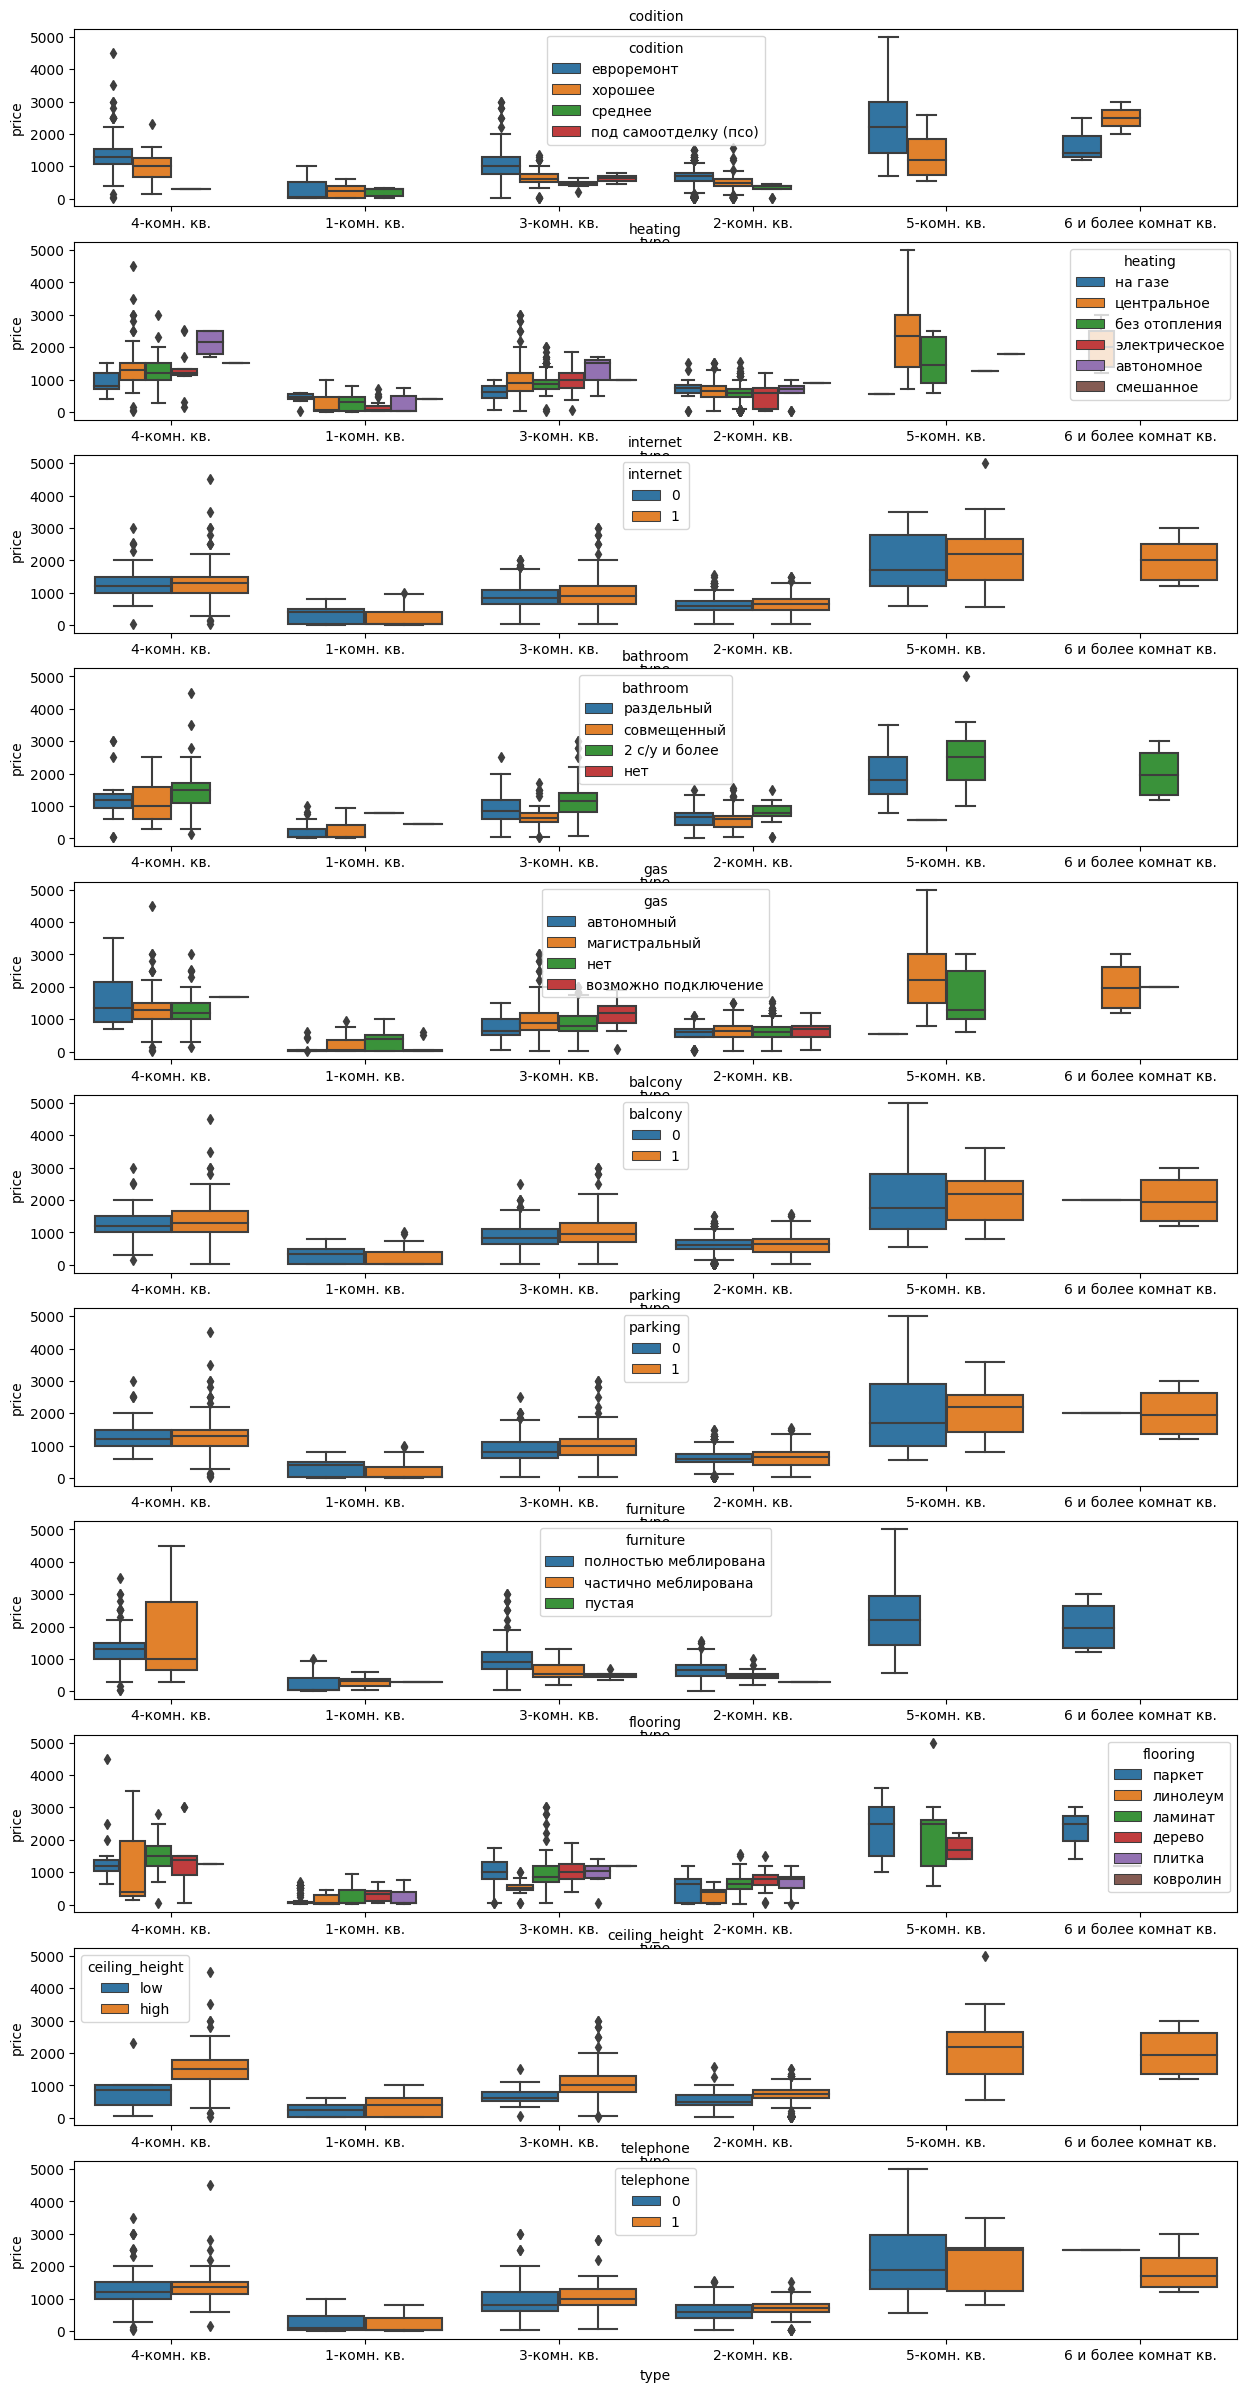

In [121]:
components = ['codition', 'heating', 'internet', 'bathroom', 'gas', 'balcony', 'parking', 'furniture', 'flooring', 'ceiling_height', 'telephone']

f, axes = plt.subplots(11, 1, figsize=(15, 30))
for c in components:
  sns.boxplot(data = df[df.type.isin(appartments)], x='type', y = 'price', hue = c, ax = axes[components.index(c)]).set_title(c, fontsize=10)

And so we see that features don't affect the price and possibly can be dropped. We will see within baseline models assesment


In [122]:
# df.equipment += df.internet + df.balcony +df.parking + df.telephone
# df.drop(['internet', 'balcony', 'parking', 'telephone'], axis = 1, inplace = True)

## Baseline models

In [123]:
! pip install optuna
! pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 8.2 MB/s eta 0:00:00


In [124]:
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
from optuna.samplers import TPESampler

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, RandomizedSearchCV, ShuffleSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

from sklearn.svm import SVC
from sklearn.svm import SVR

from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import lightgbm as lgb

from mlxtend.regressor import StackingCVRegressor

In [125]:
X = df.drop(["price"], axis=1)
y = df["price"]

In [126]:
X.columns

Index(['type', 'space', 'location', 'period_of_rent', 'proposal_type', 'batch',
       'building_age', 'building_type', 'floor', 'number_of_floors',
       'codition', 'heating', 'internet', 'bathroom', 'gas', 'balcony',
       'parking', 'furniture', 'flooring', 'ceiling_height', 'telephone',
       'safety', 'equipment'],
      dtype='object')

There are cases, when model works beter with not all features. Lets's check

In [127]:
batch_1 = ['type', 'space', 'location', 'period_of_rent', 'proposal_type', 'building_age', 'building_type', 'batch']
batch_2 = ['type', 'space', 'location', 'period_of_rent', 'proposal_type', 'building_age', 'building_type', 'batch',
           'floor', 'number_of_floors', 'safety', 'equipment']
batch_3 = ['type', 'space', 'location', 'period_of_rent', 'proposal_type', 'batch', 'building_age', 'building_type',
           'floor', 'number_of_floors', 'codition', 'heating', 'internet', 'bathroom', 'gas', 'balcony', 'parking',
           'furniture', 'flooring', 'ceiling_height', 'telephone', 'safety', 'equipment']

batches = [batch_1, batch_2, batch_3]
results_table = []
results = []

for b in batches:
  X_test = X[b]
  X_test = pd.get_dummies(X_test)
  print('Batch:', b)

  # evaluate models and baches
  models = []
  models.append(('Linear Regression', LinearRegression()))
  models.append(('Ridge Regression', Ridge(alpha=1.0)))
  models.append(('ElasticNet', ElasticNet()))
  models.append(('Lasso', Lasso(random_state=42)))
  models.append(('DecisionTreeRegressor', DecisionTreeRegressor(random_state=42)))
  models.append(('Random Forest', RandomForestRegressor(n_estimators=100, random_state=42)))
  models.append(('XGBoost Regressor', XGBRegressor(objective='reg:squarederror', random_state=42)))
  models.append(('CatBoost', CatBoostRegressor(verbose = False, random_state=42)))
  models.append(('Gradient Boosting Regressor', GradientBoostingRegressor()))


  # set table to table to populate with performance results
  rmse_results = []
  names = []
  col = ['Algorithm', 'RMSE Mean', 'RMSE SD']
  df_results = pd.DataFrame(columns=col)

  # evaluate each model using cross-validation
  kfold = KFold(n_splits=3, shuffle = True, random_state=42)
  i = 0
  for name, model in models:
      # -mse scoring
      cv_mse_results = cross_val_score(
          model, X_test, y, cv=kfold, scoring='neg_mean_squared_error')
      # calculate and append rmse results
      cv_rmse_results = np.sqrt(-cv_mse_results)
      rmse_results.append(cv_rmse_results)
      names.append(name)
      df_results.loc[i] = [name,
                          round(cv_rmse_results.mean(), 4),
                          round(cv_rmse_results.std(), 4)]
      i += 1

  results_table.append(df_results.sort_values(by=['RMSE Mean'], ascending=True).reset_index(drop=True))
  results.append(rmse_results)


Batch: ['type', 'space', 'location', 'period_of_rent', 'proposal_type', 'building_age', 'building_type', 'batch']
Batch: ['type', 'space', 'location', 'period_of_rent', 'proposal_type', 'building_age', 'building_type', 'batch', 'floor', 'number_of_floors', 'safety', 'equipment']
Batch: ['type', 'space', 'location', 'period_of_rent', 'proposal_type', 'batch', 'building_age', 'building_type', 'floor', 'number_of_floors', 'codition', 'heating', 'internet', 'bathroom', 'gas', 'balcony', 'parking', 'furniture', 'flooring', 'ceiling_height', 'telephone', 'safety', 'equipment']


In [128]:
i = 1
for r in results_table:
  print(f'********************Batch #{i}*************************')
  print(r)
  i +=1

********************Batch #1*************************
                     Algorithm  RMSE Mean  RMSE SD
0                Random Forest   834.4093 128.7016
1  Gradient Boosting Regressor   841.5161 116.6194
2                     CatBoost   865.4163 136.8689
3            XGBoost Regressor   889.2155 126.0654
4        DecisionTreeRegressor   938.3929 109.5034
5                        Lasso  1313.7057 480.6257
6             Ridge Regression  1318.1183 484.9022
7            Linear Regression  1318.8846 482.4917
8                   ElasticNet  1363.6108 491.3018
********************Batch #2*************************
                     Algorithm  RMSE Mean  RMSE SD
0                     CatBoost   814.3585 137.8844
1  Gradient Boosting Regressor   818.2696 125.1795
2                Random Forest   818.3489 124.1957
3            XGBoost Regressor   872.7044 112.6526
4        DecisionTreeRegressor   926.6029 149.5467
5                        Lasso  1312.5087 480.8138
6             Ridge Regre

The best result is result with features from batch #3

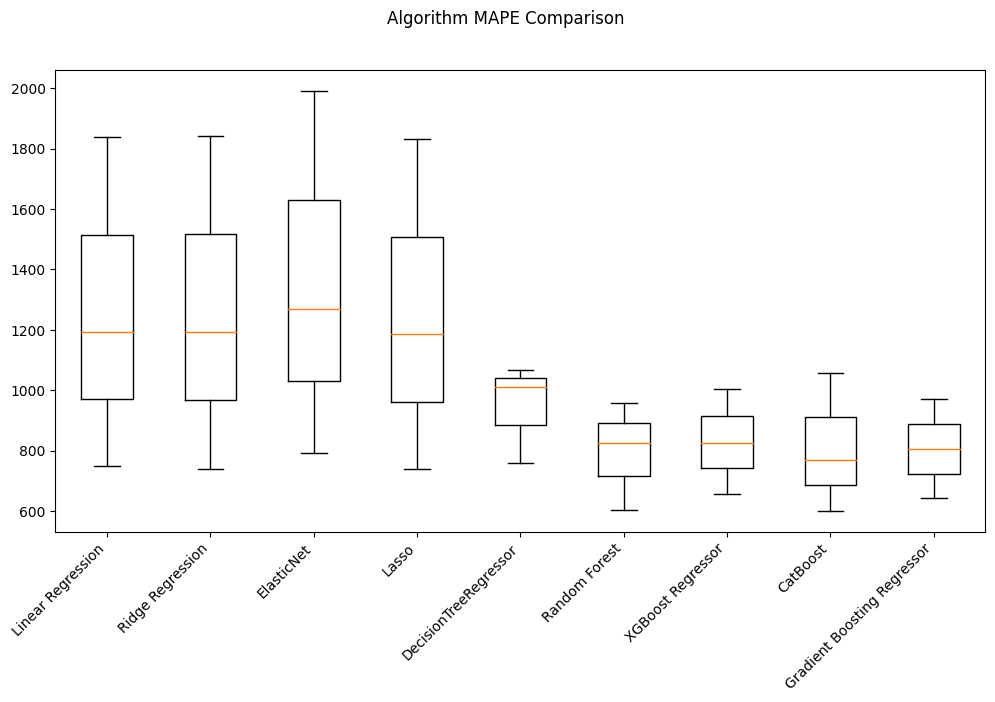

In [129]:
fig = plt.figure(figsize=(12, 6))
fig.suptitle('Algorithm MAPE Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results[2])
ax.set_xticklabels(names)
plt.xticks(rotation=45, ha='right')
plt.show();

## Tuning ML Hyper-Parameters

In [130]:
X = X[batch_3]

In [131]:
X = pd.get_dummies(X)

In [132]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=42, shuffle=True)

In [133]:
X_train.head(3)

,space,batch,internet,balcony,parking,telephone,safety,equipment,type_1-комн. кв.,type_2-комн. кв.,...,furniture_пустая,furniture_частично меблирована,flooring_дерево,flooring_ковролин,flooring_ламинат,flooring_линолеум,flooring_паркет,flooring_плитка,ceiling_height_high,ceiling_height_low
2873,50.0000,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2734,80.0000,0,0,1,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2127,50.0000,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [134]:
optuna_results = {}

### Lasso Regression

In [135]:
def objective(trial):

    model = Lasso(
        alpha=trial.suggest_float('alpha', 1e-5,1e3, log = True),
        random_state=42)

    score = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', n_jobs=-1, cv=3)
    RMSE = (score.mean() * -1) ** 0.5
    return RMSE

study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_jobs=-1, n_trials=100)

print("Number of completed trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial

print("\tBest Score: {}".format(trial.value))
print("\tBest Params: ")
for key, value in trial.params.items():
    print("\t\t{} = {},".format(key, value))


lasso_best_param = study.best_params
optuna_results['Lasso'] = trial.value

Number of completed trials: 100
Best trial:
	Best Score: 733.153380351545
	Best Params: 
		alpha = 6.635791798384112,


### Elastic Net Regression

In [136]:
def objective(trial):

    model = ElasticNet(
        alpha=trial.suggest_float('alpha', 1e-5,1e3, log = True),
        l1_ratio = trial.suggest_float('l1_ratio', 0.1, 0.9, log = True),
        random_state=42)

    score = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', n_jobs=-1, cv=3)
    RMSE = (score.mean() * -1) ** 0.5
    return RMSE

study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_jobs=-1, n_trials=100)

print("Number of completed trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial

print("\tBest Score: {}".format(trial.value))
print("\tBest Params: ")
for key, value in trial.params.items():
    print("\t\t{} = {},".format(key, value))


ElasticNet_best_param = study.best_params
optuna_results['ElasticNet'] = trial.value

Number of completed trials: 100
Best trial:
	Best Score: 732.4555151407867
	Best Params: 
		alpha = 0.009700861953467426,
		l1_ratio = 0.1670038594111796,


### Kernel Ridge Regression

In [137]:
def objective(trial):

    model = Ridge(
        alpha = trial.suggest_float('alpha',1e-4, 1e3, log = True),
    )

    score = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', n_jobs=-1, cv=3)
    RMSE = (score.mean() * -1) ** 0.5
    return RMSE

study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_jobs=-1, n_trials=100)

print("Number of completed trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial

print("\tBest Score: {}".format(trial.value))
print("\tBest Params: ")
for key, value in trial.params.items():
    print("\t\t{} = {},".format(key, value))


Ridge_best_param = study.best_params
optuna_results['Ridge'] = trial.value

Number of completed trials: 100
Best trial:
	Best Score: 732.4558442401061
	Best Params: 
		alpha = 11.811562366181882,


### DecisionTreeRegressor

In [138]:
def objective(trial):

    model = DecisionTreeRegressor(
        criterion='squared_error',
        max_depth = trial.suggest_int('max_depth', 3, 50),
        min_samples_split = trial.suggest_int('min_samples_split', 2, 50),
        random_state=42,
    )

    score = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', n_jobs=-1, cv=3)
    RMSE = (score.mean() * -1) ** 0.5
    return RMSE

study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_jobs=-1, n_trials=100, timeout=60*30)

print("Number of completed trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial

print("\tBest Score: {}".format(trial.value))
print("\tBest Params: ")
for key, value in trial.params.items():
    print("\t\t{} = {},".format(key, value))


DecisionTree_best_param = study.best_params
optuna_results['DecisionTree'] = trial.value

Number of completed trials: 100
Best trial:
	Best Score: 777.9610719941384
	Best Params: 
		max_depth = 45,
		min_samples_split = 9,


### RandomForestRegressor

In [139]:
def objective(trial):

    model = RandomForestRegressor(
        max_depth = trial.suggest_int("max_depth", 2, 50, log=True),
        n_estimators = trial.suggest_int("n_estimators", 2, 1000),
        max_leaf_nodes = trial.suggest_int("max_leaf_nodes", 2, 50),
        min_samples_split = trial.suggest_int("min_samples_split", 2, 150, log=True),
        max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2']),
        criterion='squared_error',
        random_state=42,
    )

    score = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', n_jobs=-1, cv=3)
    RMSE = (score.mean() * -1) ** 0.5
    return RMSE

study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_jobs=-1, n_trials=100, timeout=60*30)

print("Number of completed trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial

print("\tBest Score: {}".format(trial.value))
print("\tBest Params: ")
for key, value in trial.params.items():
    print("\t\t{} = {},".format(key, value))


RandomForest_best_param = study.best_params
optuna_results['RandomForest'] = trial.value

Number of completed trials: 100
Best trial:
	Best Score: 687.9069399740165
	Best Params: 
		max_depth = 10,
		n_estimators = 634,
		max_leaf_nodes = 49,
		min_samples_split = 2,
		max_features = auto,


### XGBRegressor

In [140]:
def objective(trial):
    model = XGBRegressor(
        max_depth= trial.suggest_int('max_depth', 1, 16),
        learning_rate= trial.suggest_float('learning_rate', 1e-5,1e-1, log=True),
        n_estimators= trial.suggest_int('n_estimators', 50, 1000),
        random_state= 42
    )

    score = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', n_jobs=-1, cv=3)
    RMSE = (score.mean() * -1) ** 0.5
    return RMSE

# study
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_jobs=-1, n_trials=100, timeout=60*30)

# print params
print("Number of completed trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial

print("\tBest Score: {}".format(trial.value))
print("\tBest Params: ")
for key, value in trial.params.items():
    print("\t\t{} = {},".format(key, value))

# save params
xgbr_best_params = study.best_params
optuna_results['XGBRegressor'] = trial.value

Number of completed trials: 100
Best trial:
	Best Score: 677.2355617640709
	Best Params: 
		max_depth = 2,
		learning_rate = 0.025624176958643274,
		n_estimators = 568,


### CatBoostRegressor

In [141]:
df.columns.values

array(['type', 'space', 'location', 'period_of_rent', 'price',
       'proposal_type', 'batch', 'building_age', 'building_type', 'floor',
       'number_of_floors', 'codition', 'heating', 'internet', 'bathroom',
       'gas', 'balcony', 'parking', 'furniture', 'flooring',
       'ceiling_height', 'telephone', 'safety', 'equipment'], dtype=object)

In [142]:
#CatBoostRegressor can work with categirical feature, without get_dummies preprocessing. Let's check result

X_cb = df.drop(["price"], axis=1)
X_cb.fillna(0, inplace = True)
categorical_columns = X_cb.columns.values.tolist()
categorical_columns.remove('space')
y_cb = df["price"]

X_train_cb, X_test_cb, y_train_cb, y_test_cb = train_test_split(X_cb, y_cb, test_size = .2, random_state=42, shuffle=True)

def objective(trial):
    model = CatBoostRegressor(
        iterations = trial.suggest_int("iterations", 30, 300),
        learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-1, log = True),
        depth =  trial.suggest_int("depth", 3, 12),
        min_data_in_leaf = trial.suggest_int("min_data_in_leaf", 2, 16),
        cat_features = categorical_columns,
        verbose = False,
        random_seed = 42
    )

    score = cross_val_score(model, X_train_cb, y_train_cb, scoring='neg_mean_squared_error', n_jobs=-1, cv=3)
    RMSE = (score.mean() * -1) ** 0.5
    return RMSE

# study
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_jobs=-1, n_trials=100, timeout=60*30)

# print params
print("Number of completed trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial

print("\tBest Score: {}".format(trial.value))
print("\tBest Params: ")
for key, value in trial.params.items():
    print("\t\t{} = {},".format(key, value))

# save params
cbookr_best_params = study.best_params
optuna_results['CatBoostRegressor'] = trial.value

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Number of completed trials: 100
Best trial:
	Best Score: 649.8466239904543
	Best Params: 
		iterations = 256,
		learning_rate = 0.09974956527389862,
		depth = 3,
		min_data_in_leaf = 13,


In [143]:
# with get_dummies preprocessing. Let's check result

def objective(trial):
    model = CatBoostRegressor(
        iterations = trial.suggest_int("iterations", 30, 300),
        learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-1, log = True),
        depth =  trial.suggest_int("depth", 3, 12),
        min_data_in_leaf = trial.suggest_int("min_data_in_leaf", 2, 16),
        verbose = False,
        random_seed = 42
    )

    score = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', n_jobs=-1, cv=3)
    RMSE = (score.mean() * -1) ** 0.5
    return RMSE

# study
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_jobs=-1, n_trials=100, timeout=60*30)

# print params
print("Number of completed trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial

print("\tBest Score: {}".format(trial.value))
print("\tBest Params: ")
for key, value in trial.params.items():
    print("\t\t{} = {},".format(key, value))

# save params
cboost_best_params_get_dummies = study.best_params
optuna_results['CatBoostRegressor_get_dummies'] = trial.value

Number of completed trials: 100
Best trial:
	Best Score: 686.1704399829234
	Best Params: 
		iterations = 300,
		learning_rate = 0.05623696279939536,
		depth = 6,
		min_data_in_leaf = 12,


CatBoostRegressor with categirical features work better!

### GradientBoosting

In [144]:
def objective(trial):
    model = GradientBoostingRegressor(
        n_estimators=trial.suggest_int('n_estimators', 10, 1000),
        learning_rate=trial.suggest_float('learning_rate', 0.01, 0.15, log = True),
        max_depth=trial.suggest_int('max_depth', 2, 15),
        max_features=trial.suggest_int('max_features', 2, 6),
        min_samples_leaf=trial.suggest_int('min_samples_leaf', 3, 50),
        random_state=42)

    score = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', n_jobs=-1, cv=3)
    RMSE = (score.mean() * -1) ** 0.5
    return RMSE

# study
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_jobs=-1, n_trials=100, timeout=60*30)

# print params
print("Number of completed trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial

print("\tBest Score: {}".format(trial.value))
print("\tBest Params: ")
for key, value in trial.params.items():
    print("\t\t{} = {},".format(key, value))

# save params
gbr_best_params = study.best_params
optuna_results['GradientBoostingRegressor'] = trial.value

Number of completed trials: 100
Best trial:
	Best Score: 726.9134445440898
	Best Params: 
		n_estimators = 920,
		learning_rate = 0.01602550742421385,
		max_depth = 11,
		max_features = 5,
		min_samples_leaf = 19,


### Comparison of results

In [145]:
# optuna results
pd.DataFrame.from_dict(optuna_results, orient='index', columns = ['Tuned RMSE'])

,Tuned RMSE
Lasso,733.1534
ElasticNet,732.4555
Ridge,732.4558
DecisionTree,777.9611
RandomForest,687.9069
XGBRegressor,677.2356
CatBoostRegressor,649.8466
CatBoostRegressor_get_dummies,686.1704
GradientBoostingRegressor,726.9134


In [146]:
# baseline results
results_table[2]

,Algorithm,RMSE Mean,RMSE SD
0,Random Forest,795.2345,145.3750
1,Gradient Boosting Regressor,805.3463,132.9711
2,CatBoost,808.5453,187.5951
3,XGBoost Regressor,828.2982,142.1256
4,DecisionTreeRegressor,945.8892,135.1962
5,Lasso,1252.2904,448.8007
6,Ridge Regression,1258.1066,452.3867
7,Linear Regression,1259.6235,448.1181
8,ElasticNet,1351.2416,492.6114


Optimized models work much bette.
We will try to improve the result by stacking

### Fitting + Stacking

In [147]:
LR = LinearRegression()

LASSO = Lasso(alpha=6.031872853662801, random_state=42)

ELASTIC = ElasticNet(
    alpha = 0.014966060135497332,
		l1_ratio = 0.46728285570839206,
    random_state=42
    )

RIDE = Ridge(alpha = 11.838337937801954)

DTR = DecisionTreeRegressor(
    criterion='squared_error',
    max_depth = 6,
		min_samples_split = 9,
    random_state=42
    )

RFR = RandomForestRegressor(
    max_depth = 7,
		n_estimators = 956,
		max_leaf_nodes = 50,
		min_samples_split = 2,
		max_features = 'auto',
    criterion='squared_error',
    random_state=42
    )

XGBR = XGBRegressor(
    max_depth = 2,
		learning_rate = 0.07040889336473456,
		n_estimators = 496,
    random_state= 42
    )

CBR = CatBoostRegressor(
    iterations = 235,
		learning_rate = 0.08171207768977089,
		depth = 5,
		min_data_in_leaf = 9,
    verbose = False,
    random_seed = 42
    )

GBR = GradientBoostingRegressor(
    n_estimators = 428,
		learning_rate = 0.06071743804672567,
		max_depth = 14,
		max_features = 4,
		min_samples_leaf = 19,
    random_state=42
    )

In [148]:
models = [
    ('Lasso', LASSO),
    ('Elastic', ELASTIC),
    ('Ride', RIDE),
    ('DecisionTree', DTR),
    ('Random Forest', RFR),
    ('XGBoost', XGBR),
    ('CatBoostRegressor', CBR),
    ('GradientBoosting', GBR),
    ]

In [149]:
results = {}
for name, model in models:
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)

    rmse = mean_squared_error(y_test, prediction, squared = False)
    results[name] = rmse

    print("-------{}-------".format(name))
    print("Root Mean Squared Error: {}".format(rmse))
    print("----------------------------------\n")

-------Lasso-------
Root Mean Squared Error: 2315.155514213722
----------------------------------

-------Elastic-------
Root Mean Squared Error: 2345.551846696113
----------------------------------

-------Ride-------
Root Mean Squared Error: 2336.004742108778
----------------------------------

-------DecisionTree-------
Root Mean Squared Error: 938.2834347449524
----------------------------------



/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


-------Random Forest-------
Root Mean Squared Error: 962.285557218718
----------------------------------

-------XGBoost-------
Root Mean Squared Error: 932.627415090939
----------------------------------

-------CatBoostRegressor-------
Root Mean Squared Error: 862.2762955543125
----------------------------------

-------GradientBoosting-------
Root Mean Squared Error: 961.3537734040253
----------------------------------



In [150]:
# StackingRegressor

base_models = [
    # ('Lasso', LASSO),
    # ('Elastic', ELASTIC),
    # ('Ride', RIDE),
    ('DecisionTree', DTR),
    # ('Random Forest', RFR),
    ('XGBoost', XGBR),
    ('CatBoostRegressor', CBR),
    ('GradientBoosting', GBR),
    ]

stacked = StackingRegressor(
    estimators = base_models,
    final_estimator = LinearRegression(),
    cv = 3)

In [151]:
stacked.fit(X_train, y_train)
stacked_prediction = stacked.predict(X_test)

stacked_rmse = mean_squared_error(y_test, stacked_prediction, squared = False)
results['Stacked'] = stacked_rmse

print("-------Stacked Ensemble-------")
print("Root Mean Squared Error: {}".format(stacked_rmse))
print("----------------------------------")

-------Stacked Ensemble-------
Root Mean Squared Error: 960.4710823303246
----------------------------------


In [152]:
# Fitting CatBoostRegressor with categorical features

model = CatBoostRegressor(
    iterations = 268,
    learning_rate = 0.0549810395937805,
    depth = 5,
    min_data_in_leaf = 15,
    cat_features = categorical_columns,
    verbose = False,
    random_seed = 42
    )

model.fit(X_train_cb, y_train_cb)
prediction = model.predict(X_test_cb)

rmse = mean_squared_error(y_test_cb, prediction, squared = False)
results['CatBoostRegressor_categorical'] = stacked_rmse

print("-------{}-------".format('CatBoostRegressor_categorical'))
print("Root Mean Squared Error: {}".format(rmse))
print("----------------------------------\n")

-------CatBoostRegressor_categorical-------
Root Mean Squared Error: 963.3449308688058
----------------------------------



## Results

In [153]:
pd.DataFrame.from_dict(results, orient='index', columns = ['Final RMSE']).sort_values(by=['Final RMSE'])

,Final RMSE
CatBoostRegressor,862.2763
XGBoost,932.6274
DecisionTree,938.2834
Stacked,960.4711
CatBoostRegressor_categorical,960.4711
GradientBoosting,961.3538
Random Forest,962.2856
Lasso,2315.1555
Ride,2336.0047
Elastic,2345.5518


We found that CatBoostRegressor works better than other models, even than tacked model.

In [154]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,space,64.8642
1,codition,15.5286
2,period_of_rent,9.7289
3,building_type,2.1168
4,type,1.6294
5,ceiling_height,1.5103
6,bathroom,1.4770
7,location,0.6255
8,heating,0.6150
9,number_of_floors,0.3398


In [156]:
model.save_model('catboost_model.bin')

# Conclusion

We prepared and evaluated several models that predict the house rental price in Kyrgyzstan.

1.   We scrapped data from 'house.kg'
2.   Extracted features from the data
3.   Visualized, cleaned and tried to find some insites
4.   Built several models and optimized hyperparameters
5.   Evaluatedall of them and found the most accurate (RMSE score)

Of course it is learning pet-project, the data scrapped from the 'house.kg' are not good and we don't have enough data to incrase the score, but we demonstrated our skills and will use them in our future work!